In [1]:
%%capture
!pip install ../input/pandasta/talib_binary-0.4.19-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/pandasta/pandas_ta-0.3.14b0-py3-none-any.whl
!pip install arch

import pandas_ta as ta

from arch import arch_model
from arch.unitroot import PhillipsPerron

In [2]:
%%capture
!pip install einops

In [3]:
import os
import gc

import numpy as np
import pandas as pd 



import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, bds, kpss

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import genextreme as gev

from random import choices, choice, randint, random

import torch
from einops import rearrange, einsum

from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 10
plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

# Price graphs

open      high       low     close
start_at                                                   
2020-03-25 00:00:00   6768.65   6768.65   6743.12   6745.30
2020-03-25 00:01:00   6745.30   6745.73   6680.09   6700.39
2020-03-25 00:02:00   6700.39   6719.09   6698.38   6707.20
2020-03-25 00:03:00   6707.20   6713.03   6692.53   6693.64
2020-03-25 00:04:00   6693.64   6710.13   6693.01   6710.13
...                       ...       ...       ...       ...
2023-02-28 23:55:00  23127.51  23128.25  23120.26  23122.79
2023-02-28 23:56:00  23122.79  23124.40  23120.44  23123.53
2023-02-28 23:57:00  23123.53  23135.59  23123.53  23125.47
2023-02-28 23:58:00  23125.47  23130.01  23122.87  23126.47
2023-02-28 23:59:00  23126.47  23141.99  23126.47  23141.99

[1542230 rows x 4 columns]

<AxesSubplot: title={'center': 'Bitcoin price'}, xlabel='start_at', ylabel='USD'>

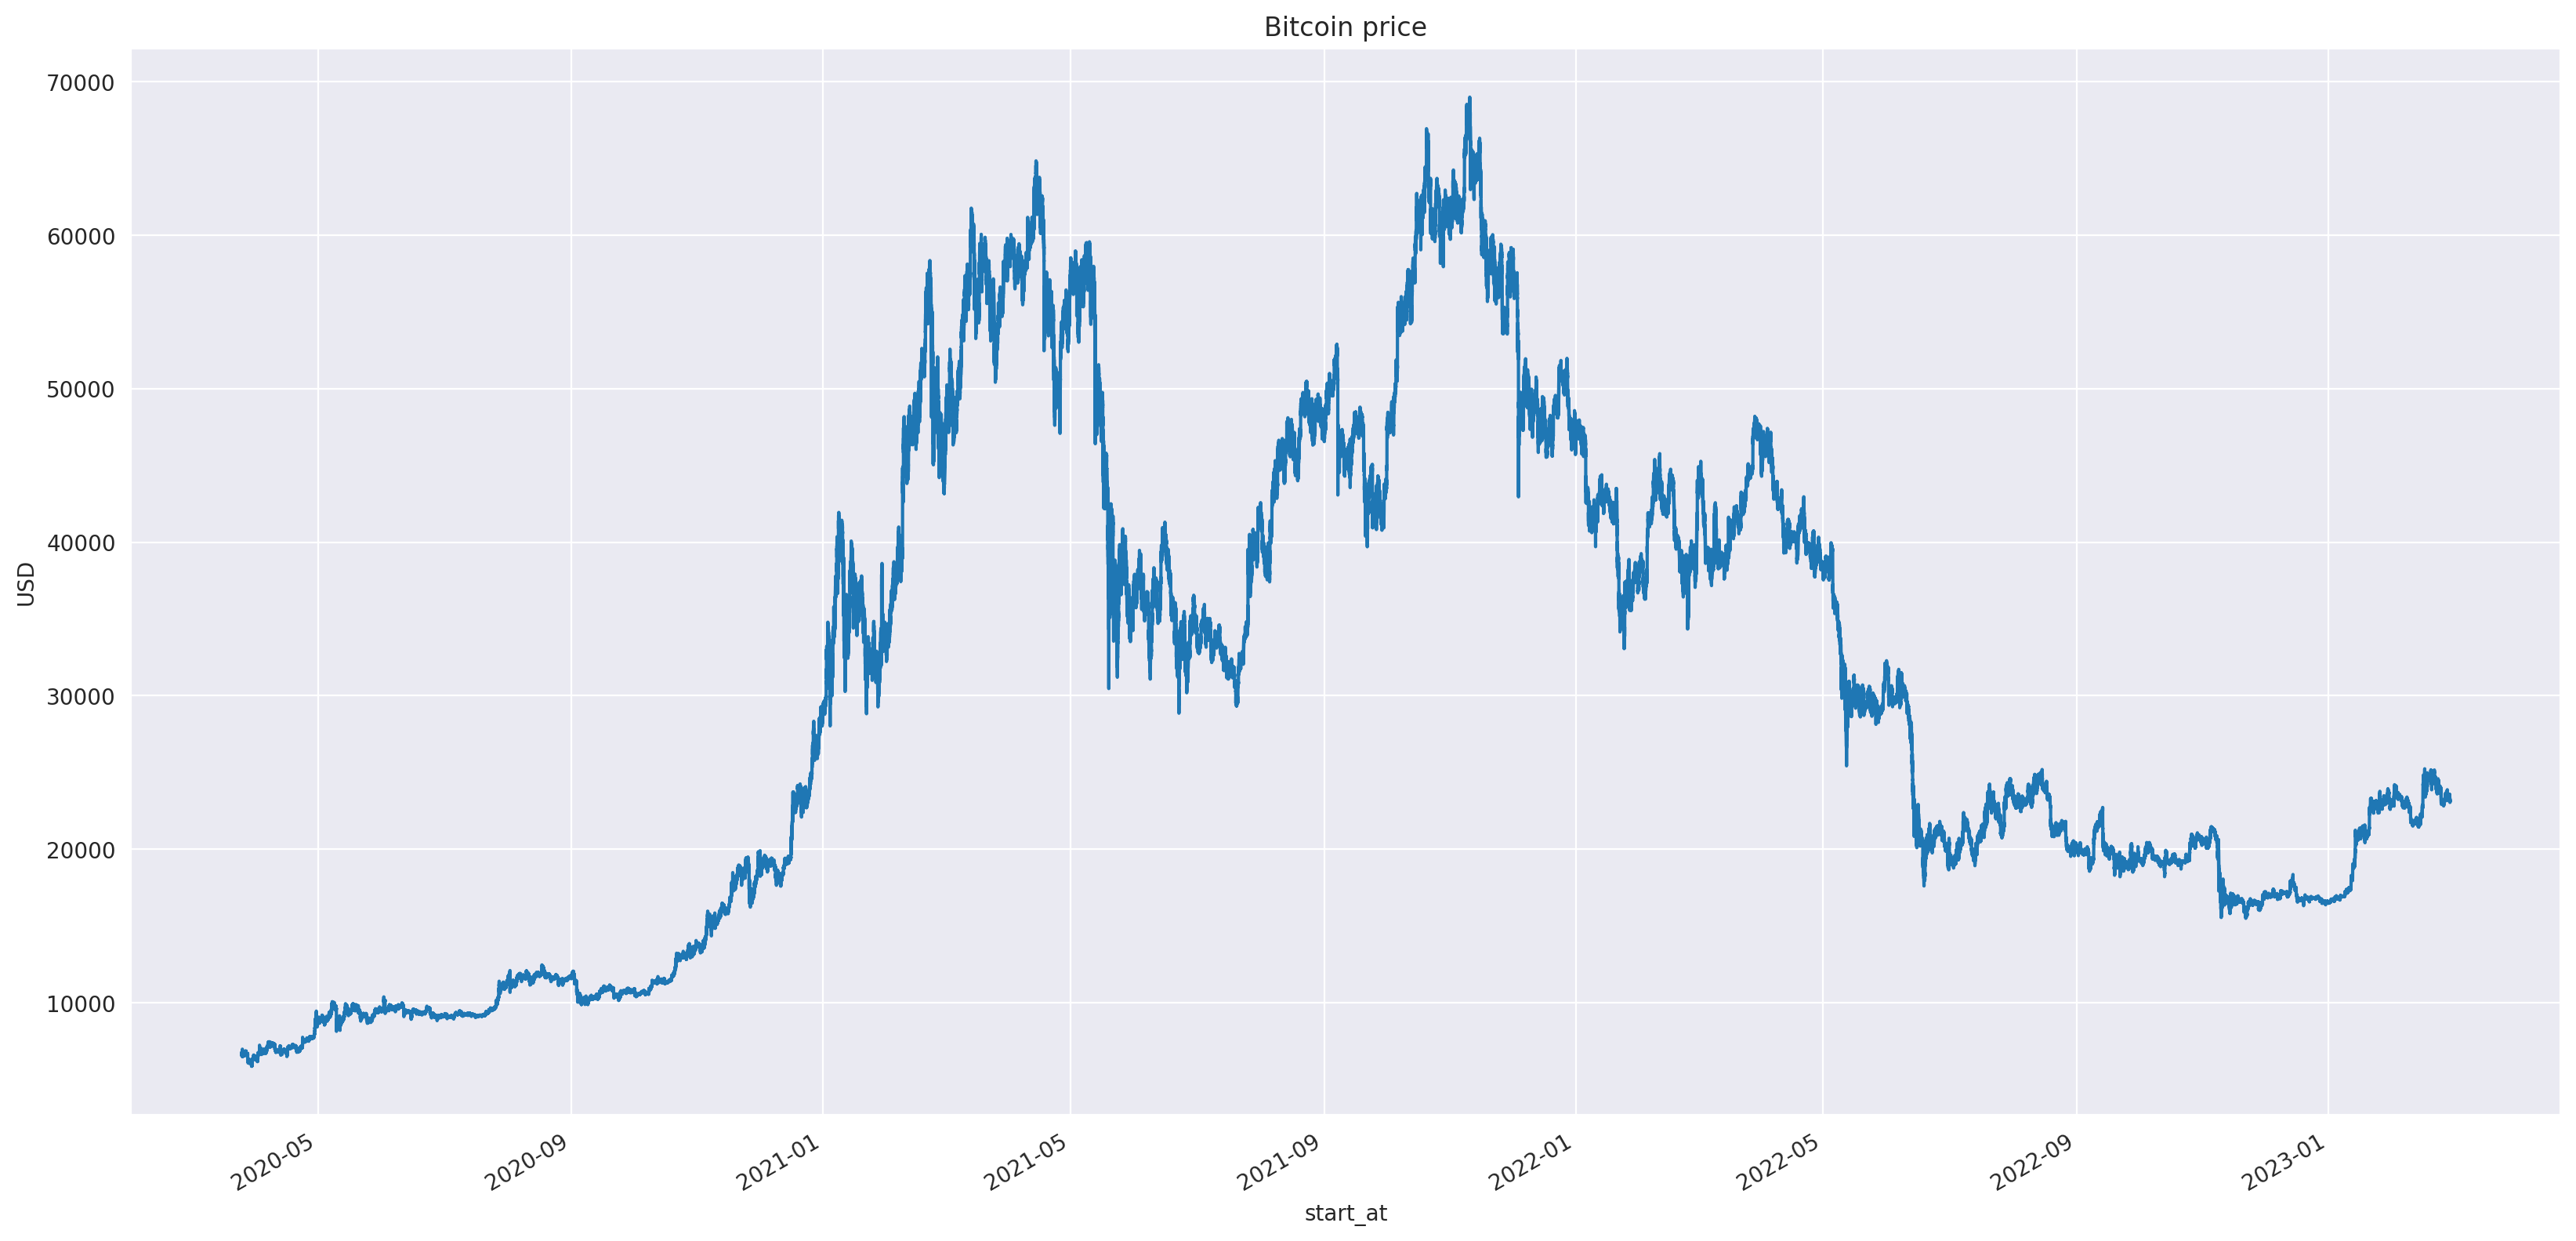

In [4]:
prices = pd.read_csv('/kaggle/input/bybit-btc-usdt/index.csv')
prices.index = pd.to_datetime(prices['start_at'], unit='s')
prices.drop(['period', 'year', 'month', 'day', 'symbol', 'start_at'], inplace=True, axis=1)
display(prices)

price = prices['open']
__price = price.values
price.plot(figsize=(20, 10), ylabel='USD', title='Bitcoin price')

count     1071.00
mean      1650.65
std       1535.50
min         69.94
25%        506.22
50%       1235.41
75%       2358.40
max      13117.81
dtype: float64

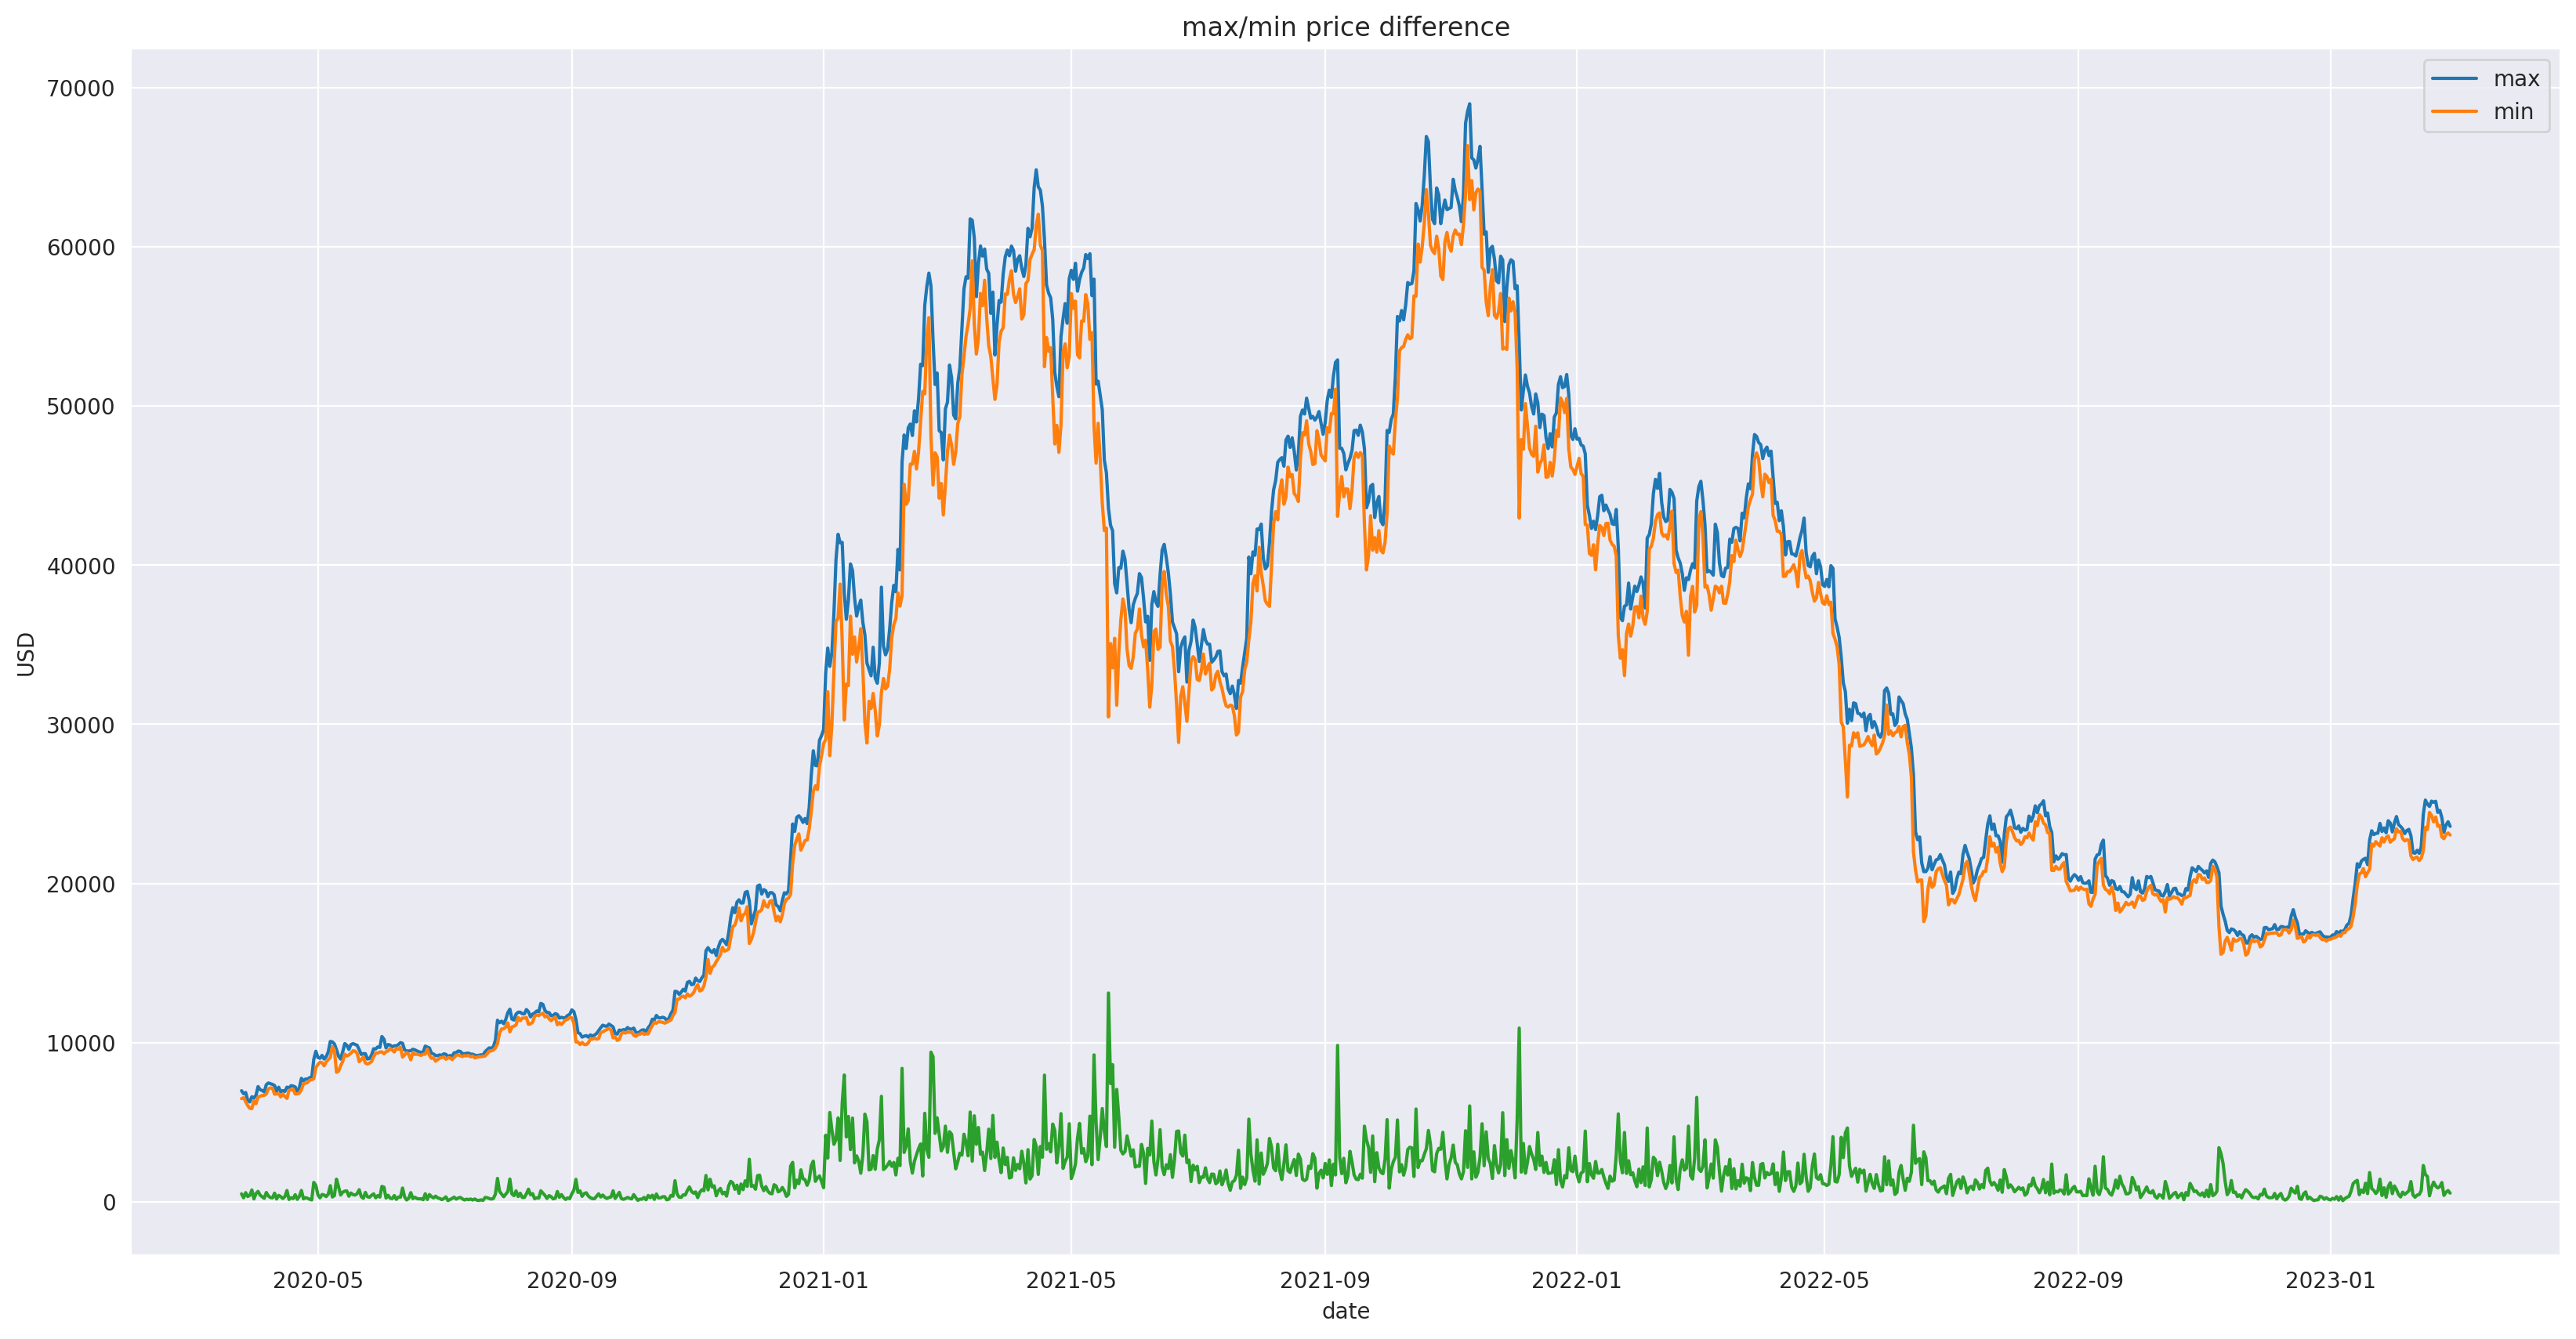

In [5]:
daily_prices = prices.groupby(prices.index.date).last()

gaps = price.groupby(prices.index.date).agg(['max', 'min']).rename({'max': 'max_price', 'min': 'min_price'})
gaps.plot(figsize=(20, 10), xlabel='date', ylabel='USD', title='max/min price difference')

difference = gaps['max'] - gaps['min']
difference.plot()

display(difference.describe().round(2))

count    1071.00
mean        5.12
std         3.50
min         0.41
25%         2.82
50%         4.28
75%         6.23
max        35.45
dtype: float64

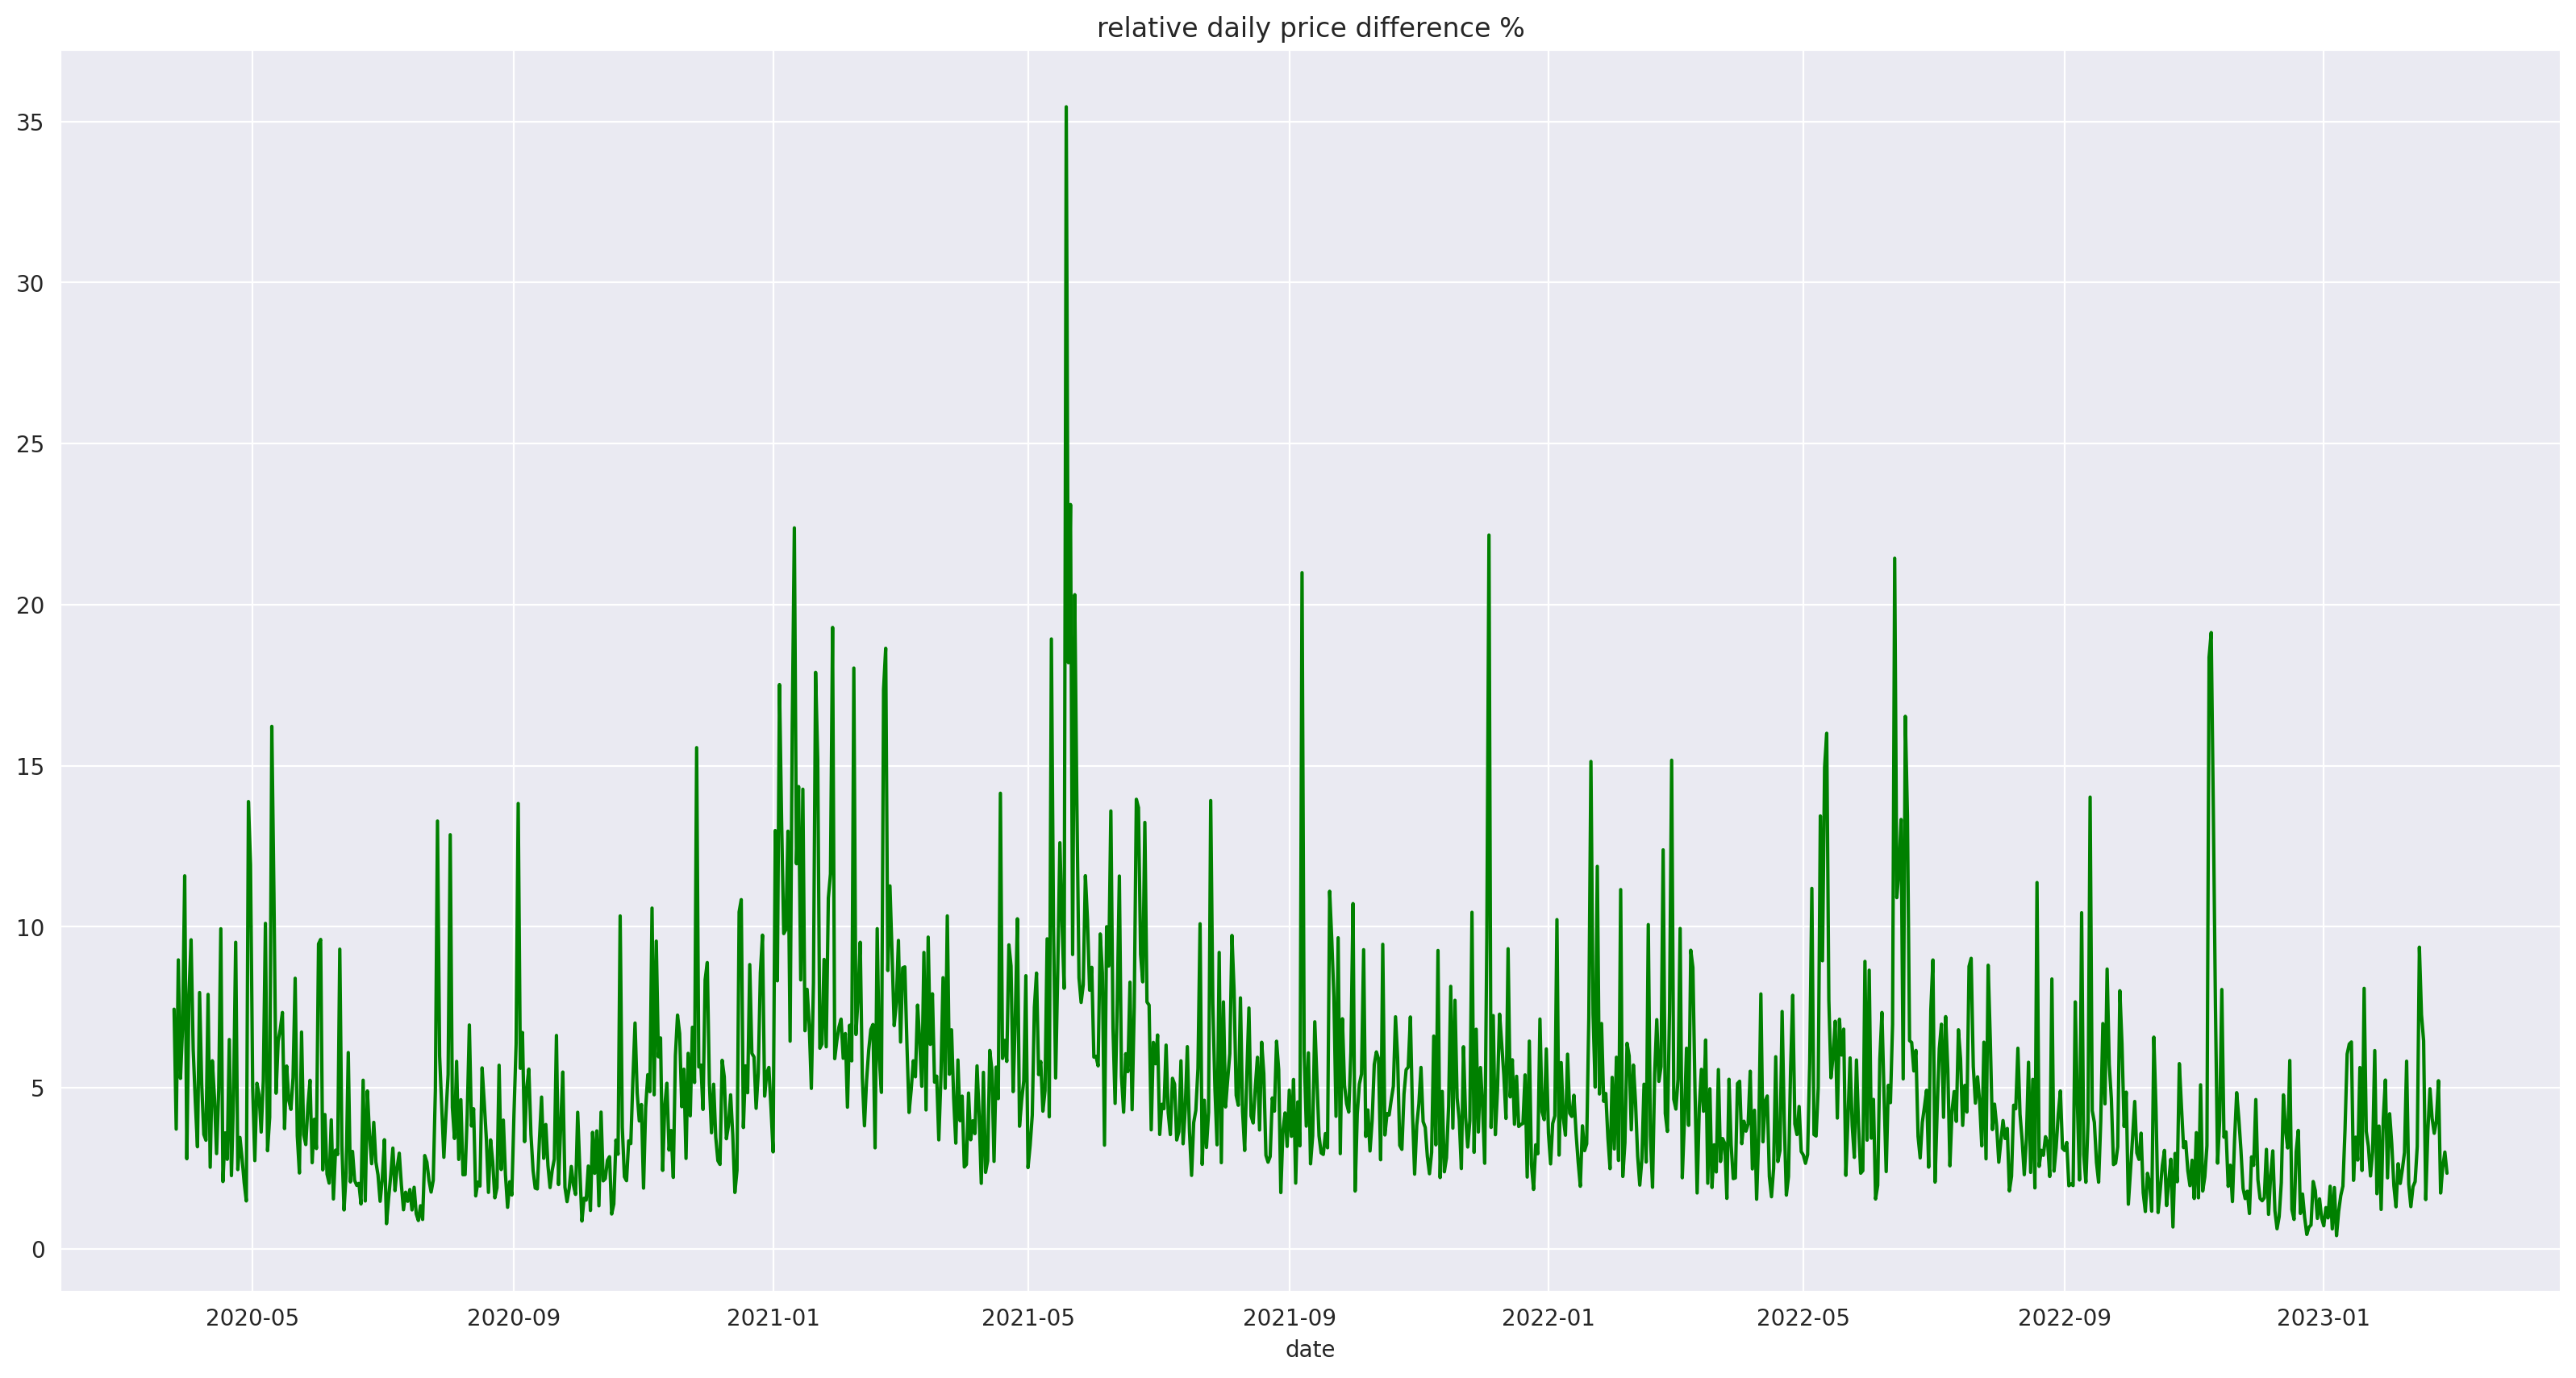

In [6]:
rel_difference = (difference / price.groupby(price.index.date).last() * 100)
display(rel_difference.describe().round(2))
rel_difference.plot(figsize=(20, 10), title='relative daily price difference %', xlabel='date', color='green');

## Moving average

<AxesSubplot: title={'center': 'Simple moving averages'}, xlabel='date'>

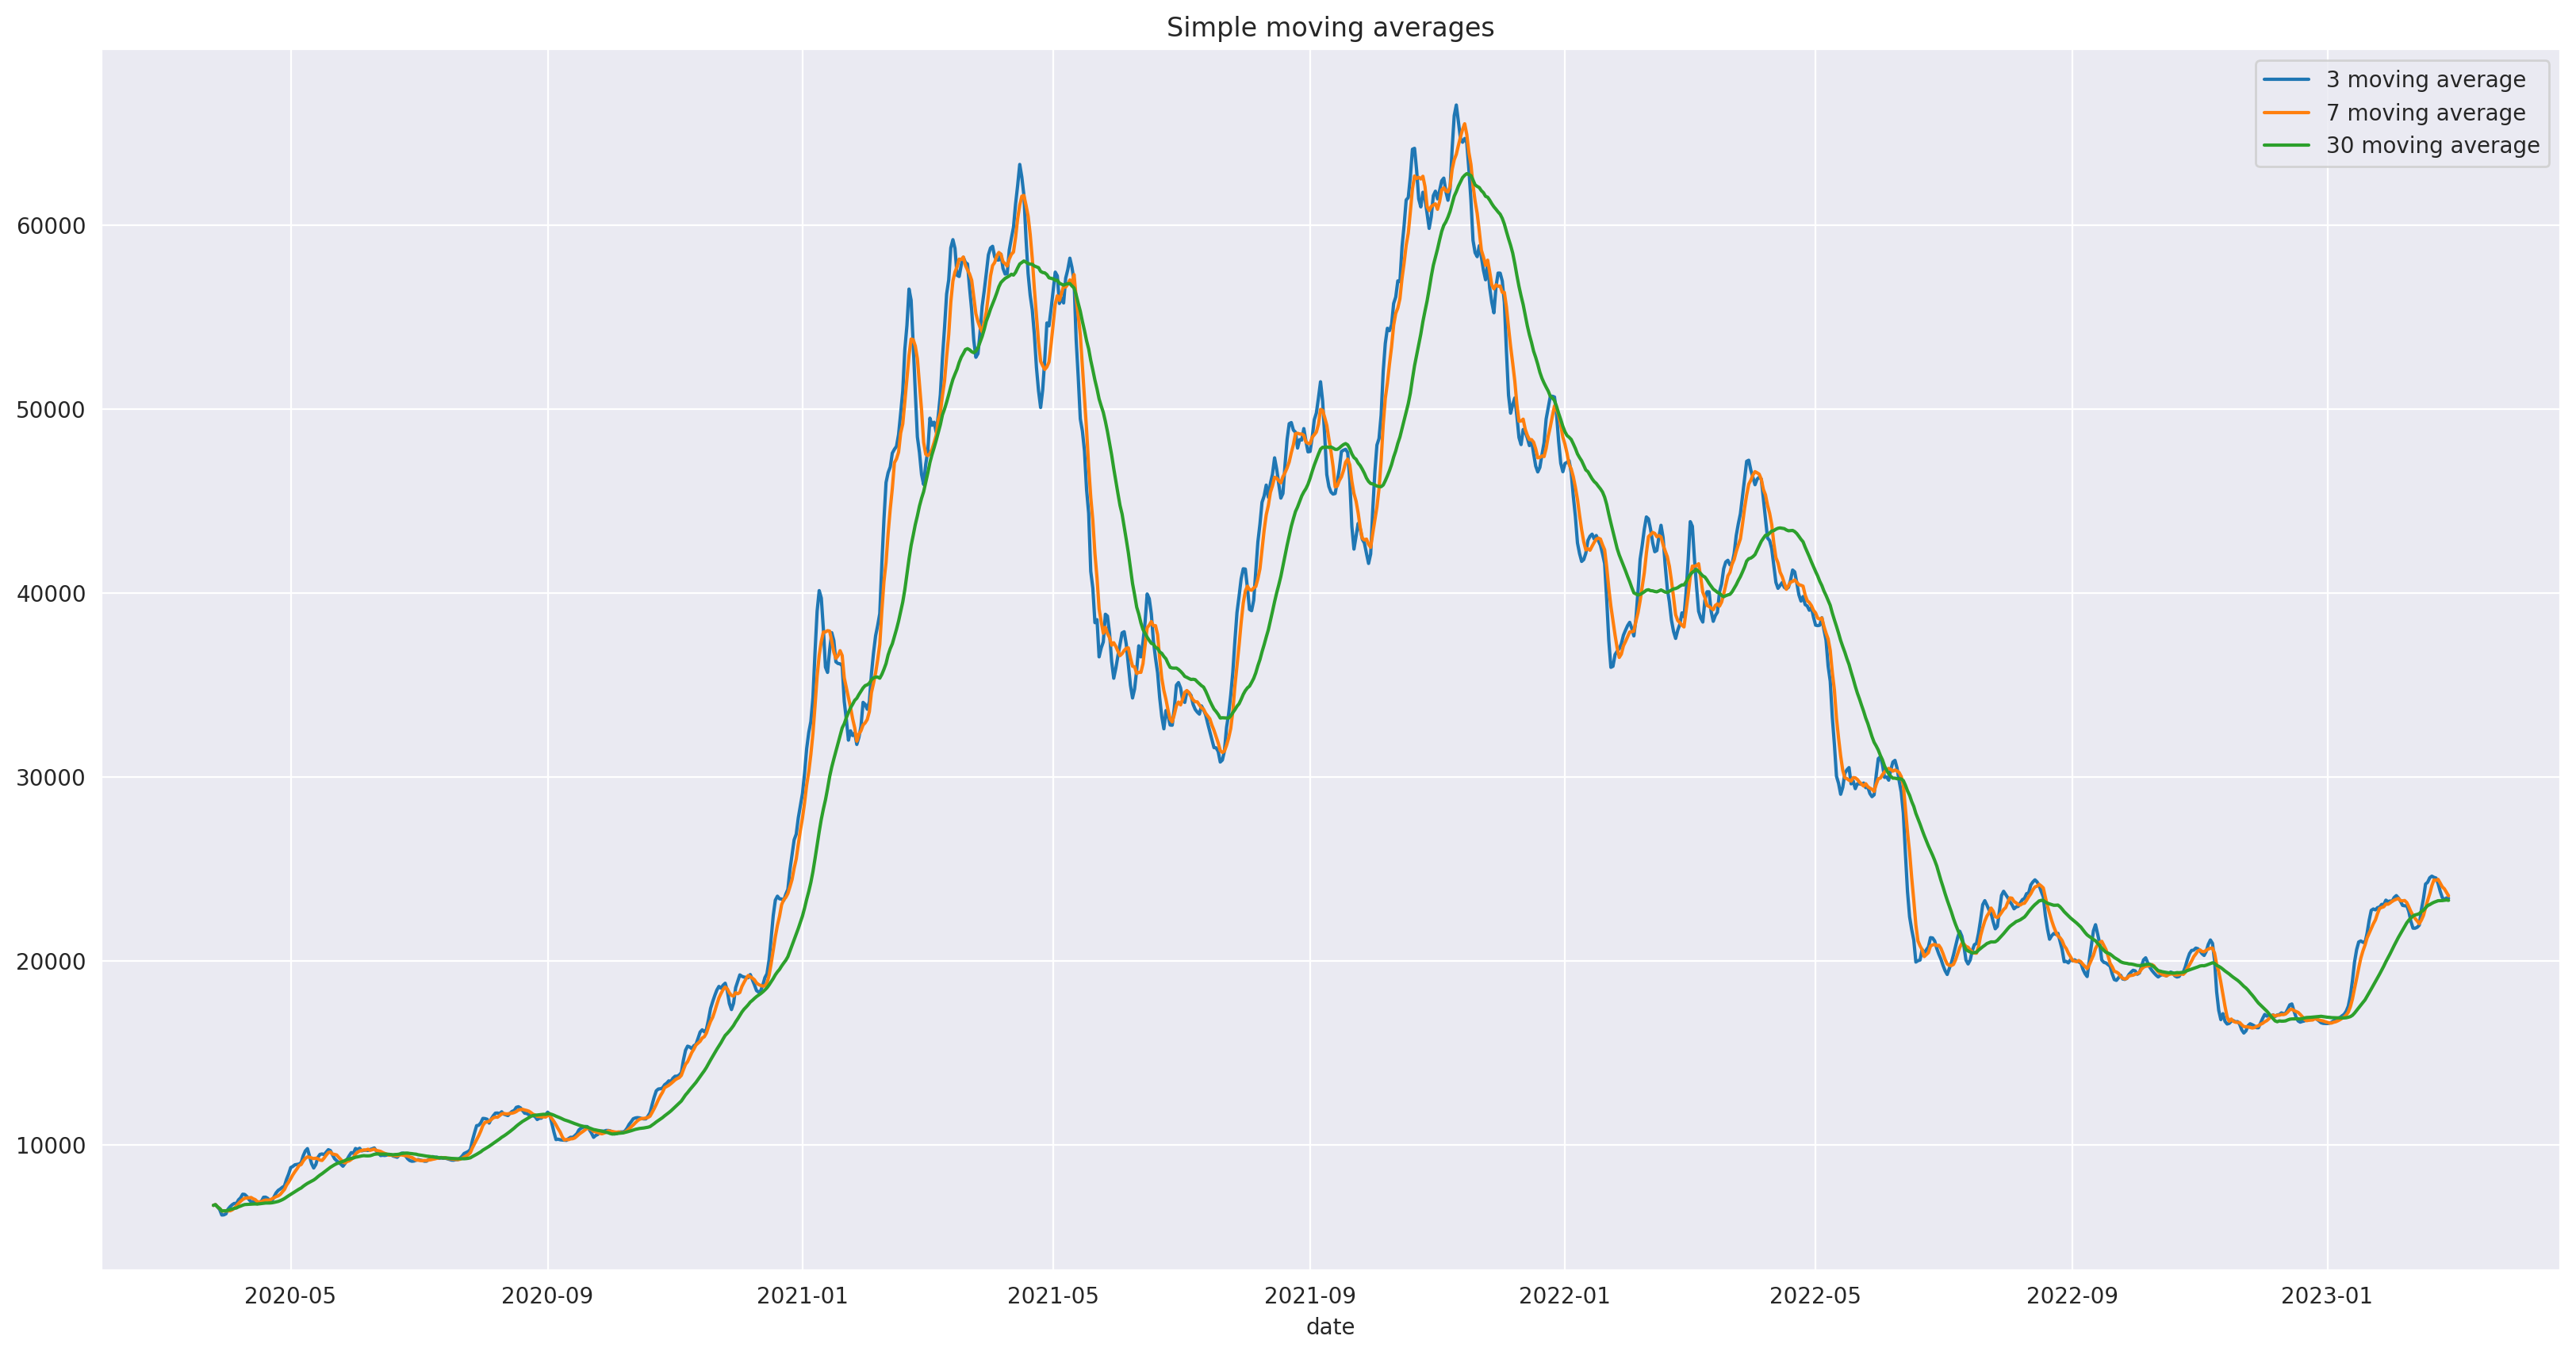

In [7]:
periods = [3, 7, 30]
ma = pd.DataFrame(index=daily_prices.index)
for period in periods:
    ma[f'{period} moving average'] = daily_prices["open"].rolling(period, min_periods=1).mean()

ma.plot(figsize=(20, 10), title='Simple moving averages', xlabel='date')

## season-trend-residual decomposition

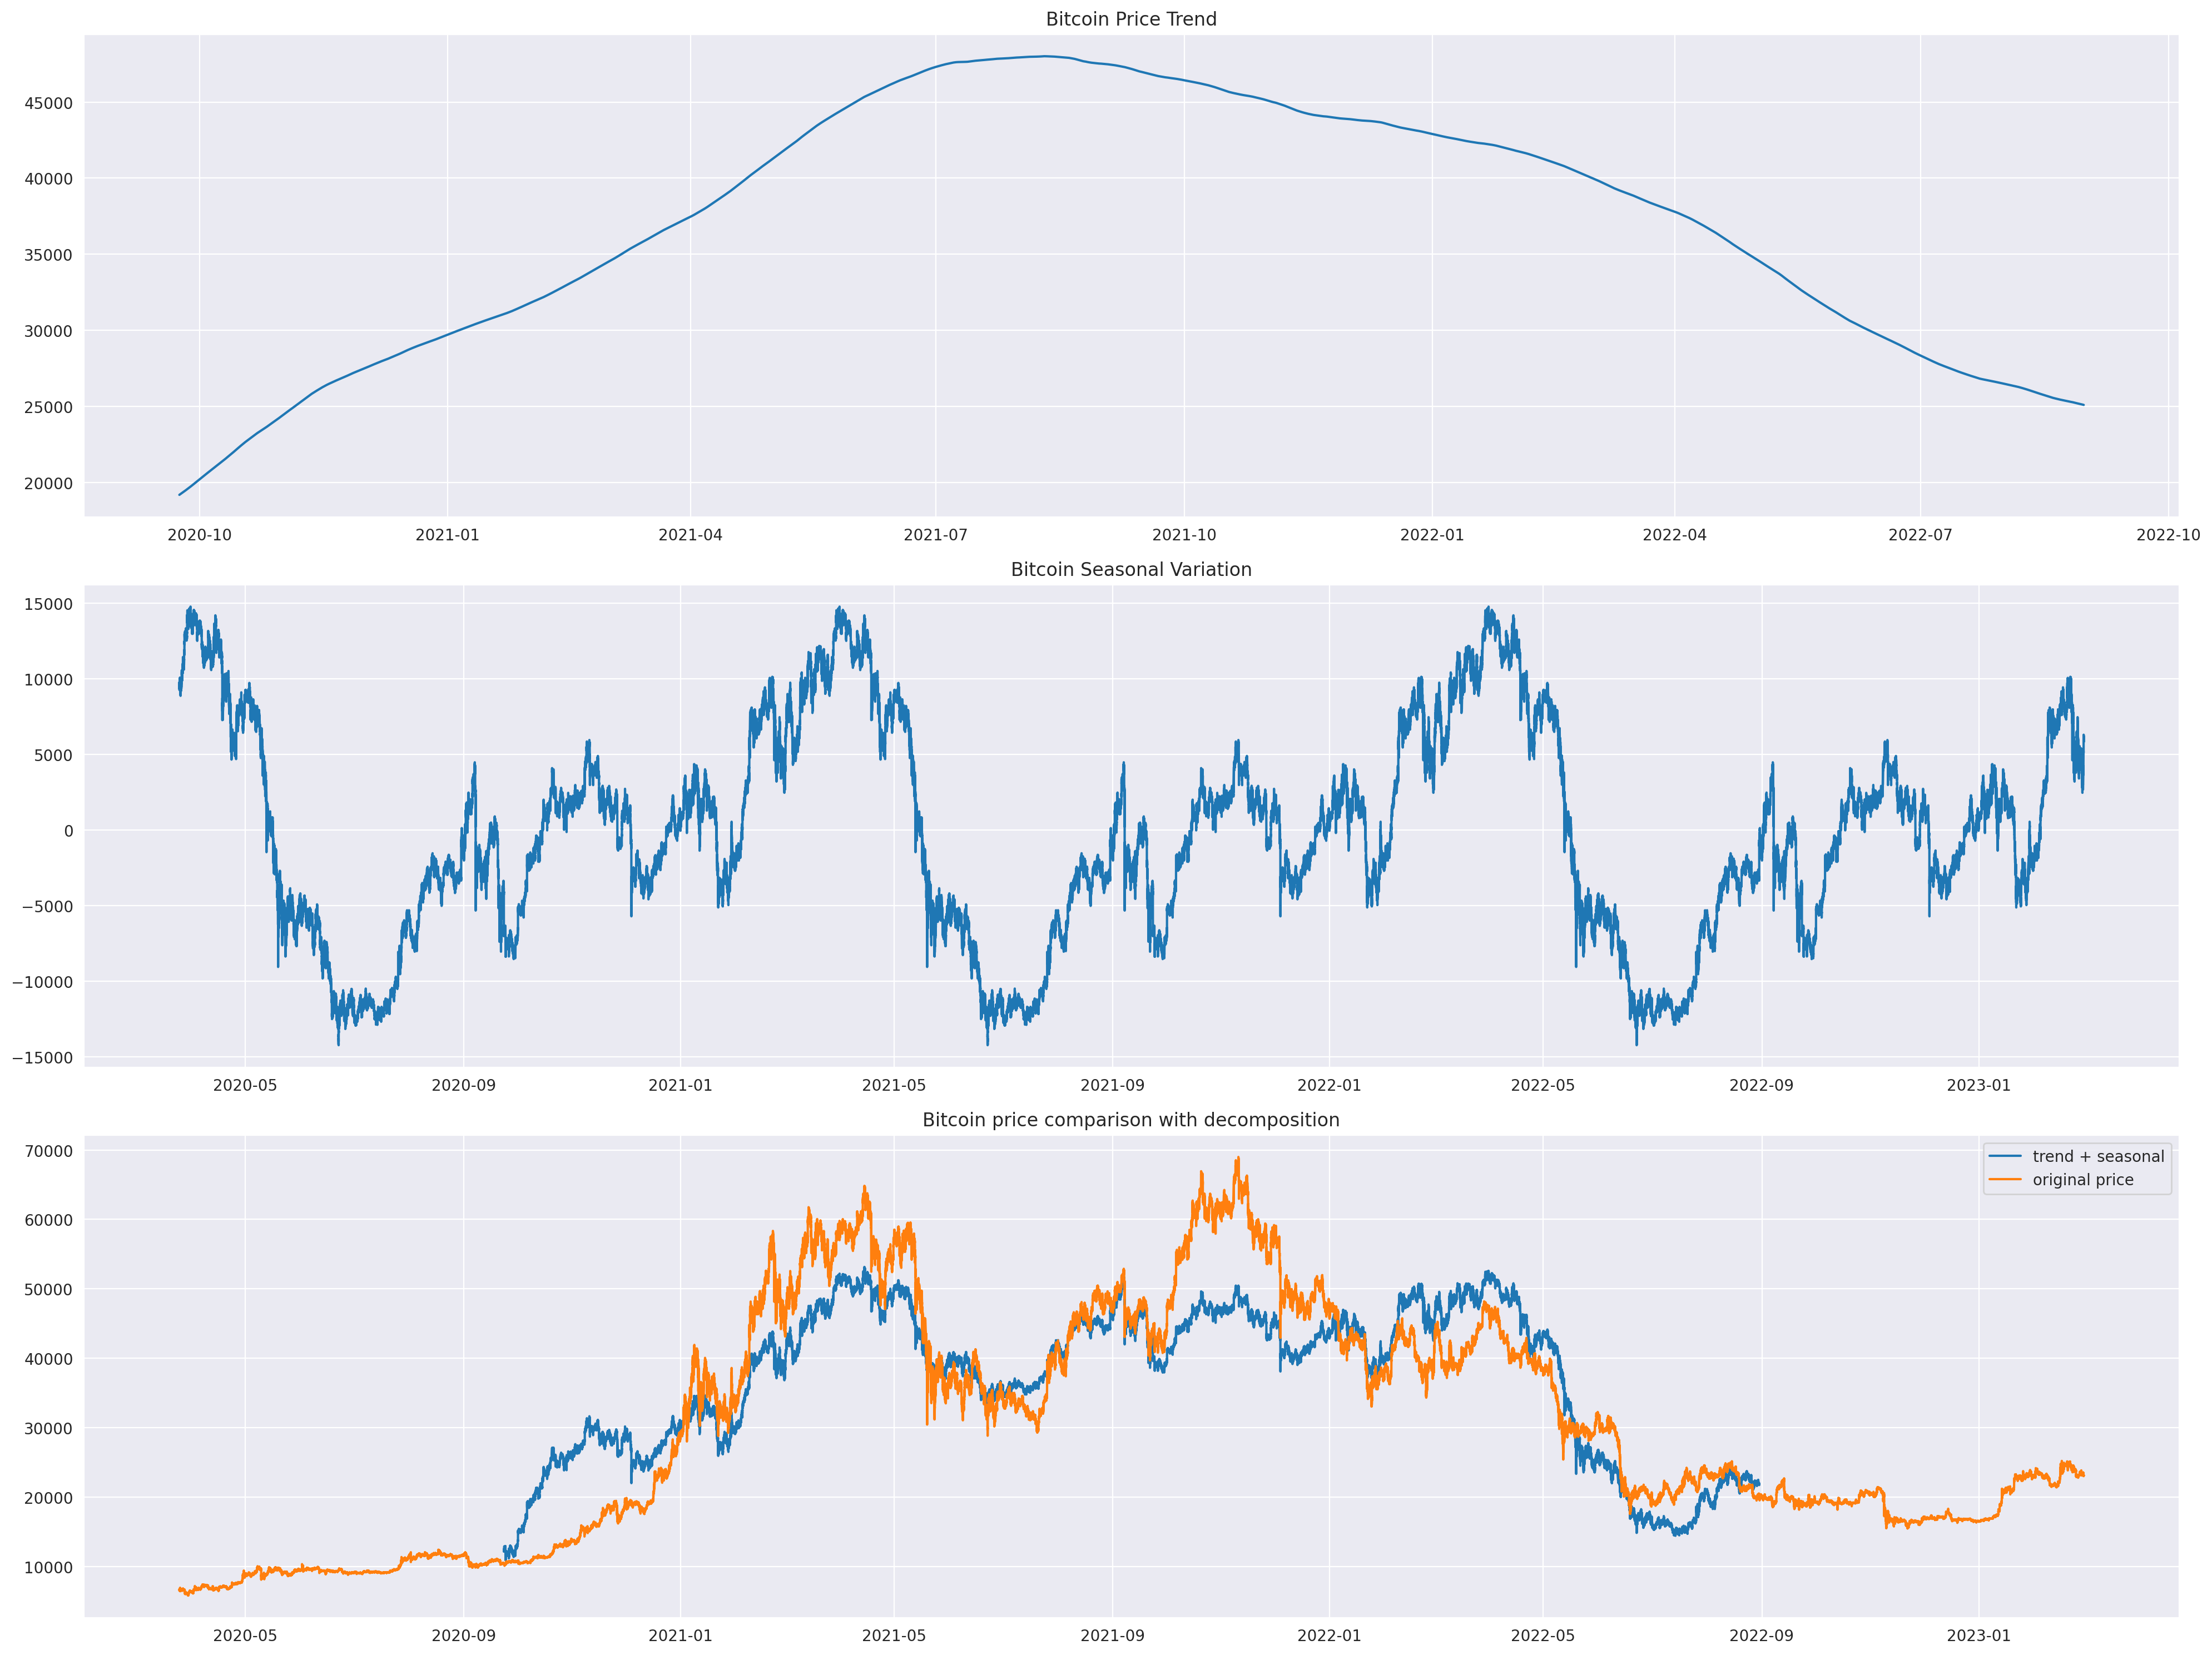

In [8]:
# Now, let's decompose the time series to observe the trend
decomposition = seasonal_decompose(price, model='additive', period=60*24*365)

# We can now plot the trend and seasonal components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,15))

# Plot trend component
ax1.plot(decomposition.trend)
ax1.set_title('Bitcoin Price Trend')

# Plot seasonal component
ax2.plot(decomposition.seasonal)
ax2.set_title('Bitcoin Seasonal Variation')

ax3.plot(decomposition.trend + decomposition.seasonal, label='trend + seasonal')
ax3.plot(price, label='original price')
ax3.set_title('Bitcoin price comparison with decomposition')
ax3.legend()

plt.tight_layout()
plt.show()

## volatility analysis

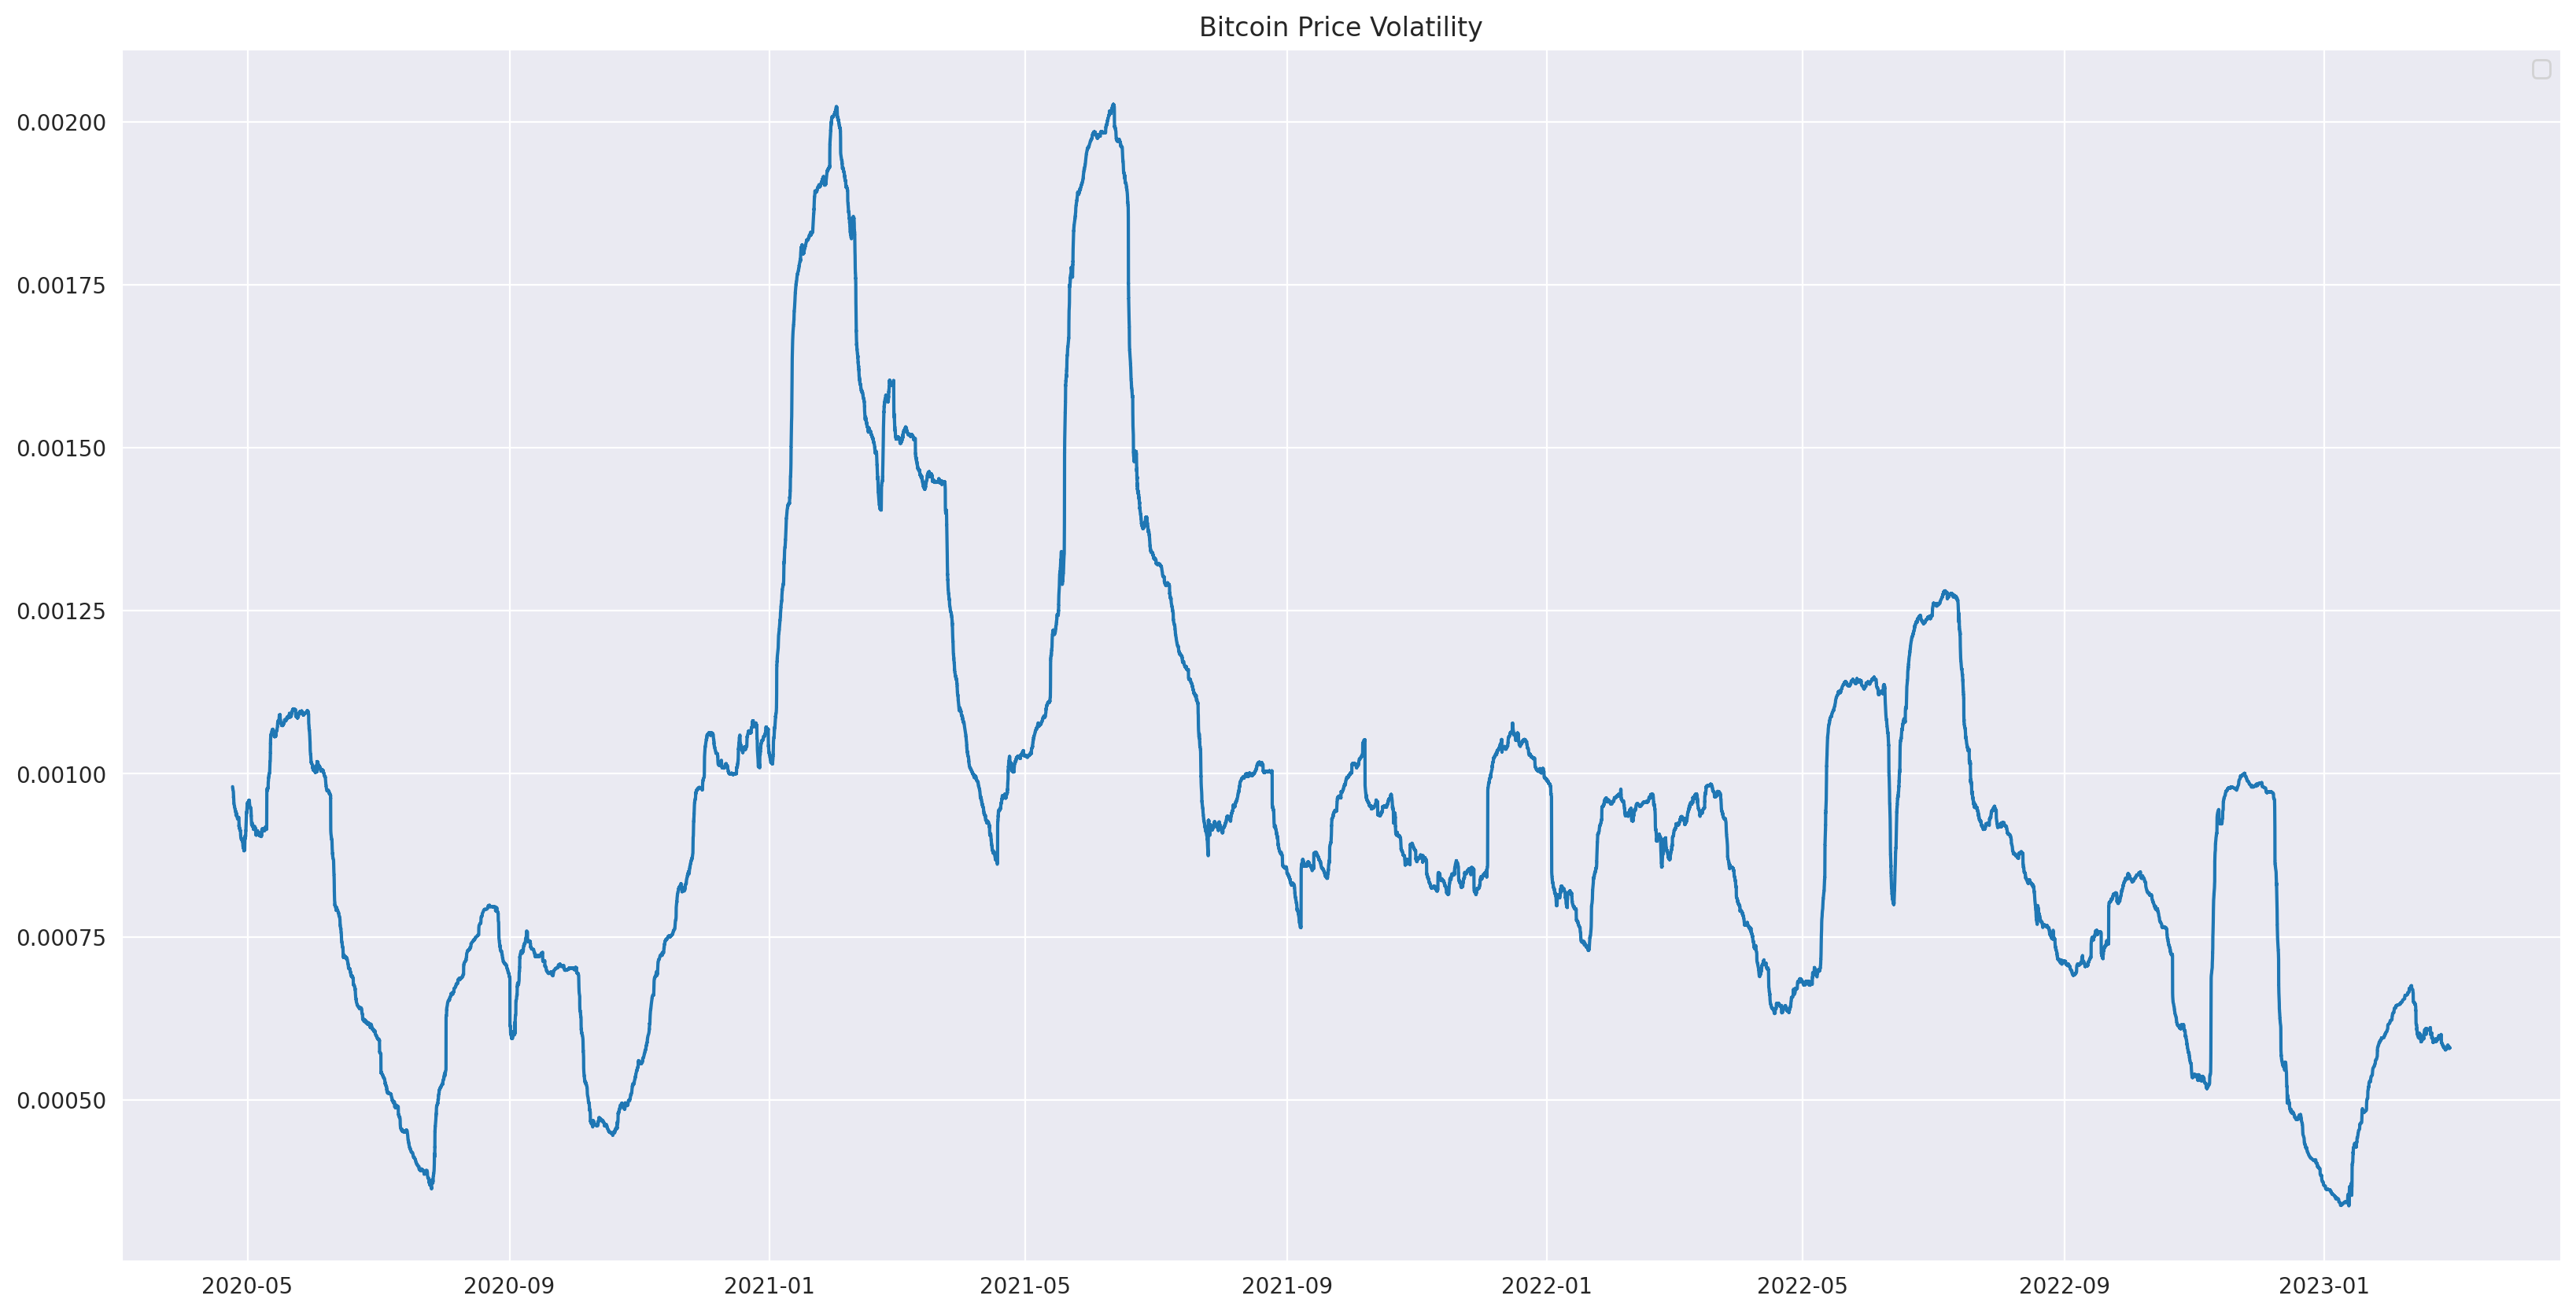

Correlation between lagged returns and volatility: 0.0007359790932116501


In [9]:
# Calculate returns
returns = price.pct_change()

window_size = 60 * 24 * 30
volatility = returns.rolling(window_size).std()

# Plot the volatility
plt.figure(figsize=(20,10))
plt.plot(volatility)
plt.title('Bitcoin Price Volatility')
plt.legend()
plt.show()

# Calculate lagged returns
lagged_returns = returns.shift(-1)
lagged_returns.dropna(inplace=True)
correlation = lagged_returns.corr(volatility)

print(f'Correlation between lagged returns and volatility: {correlation}')

## finite differences

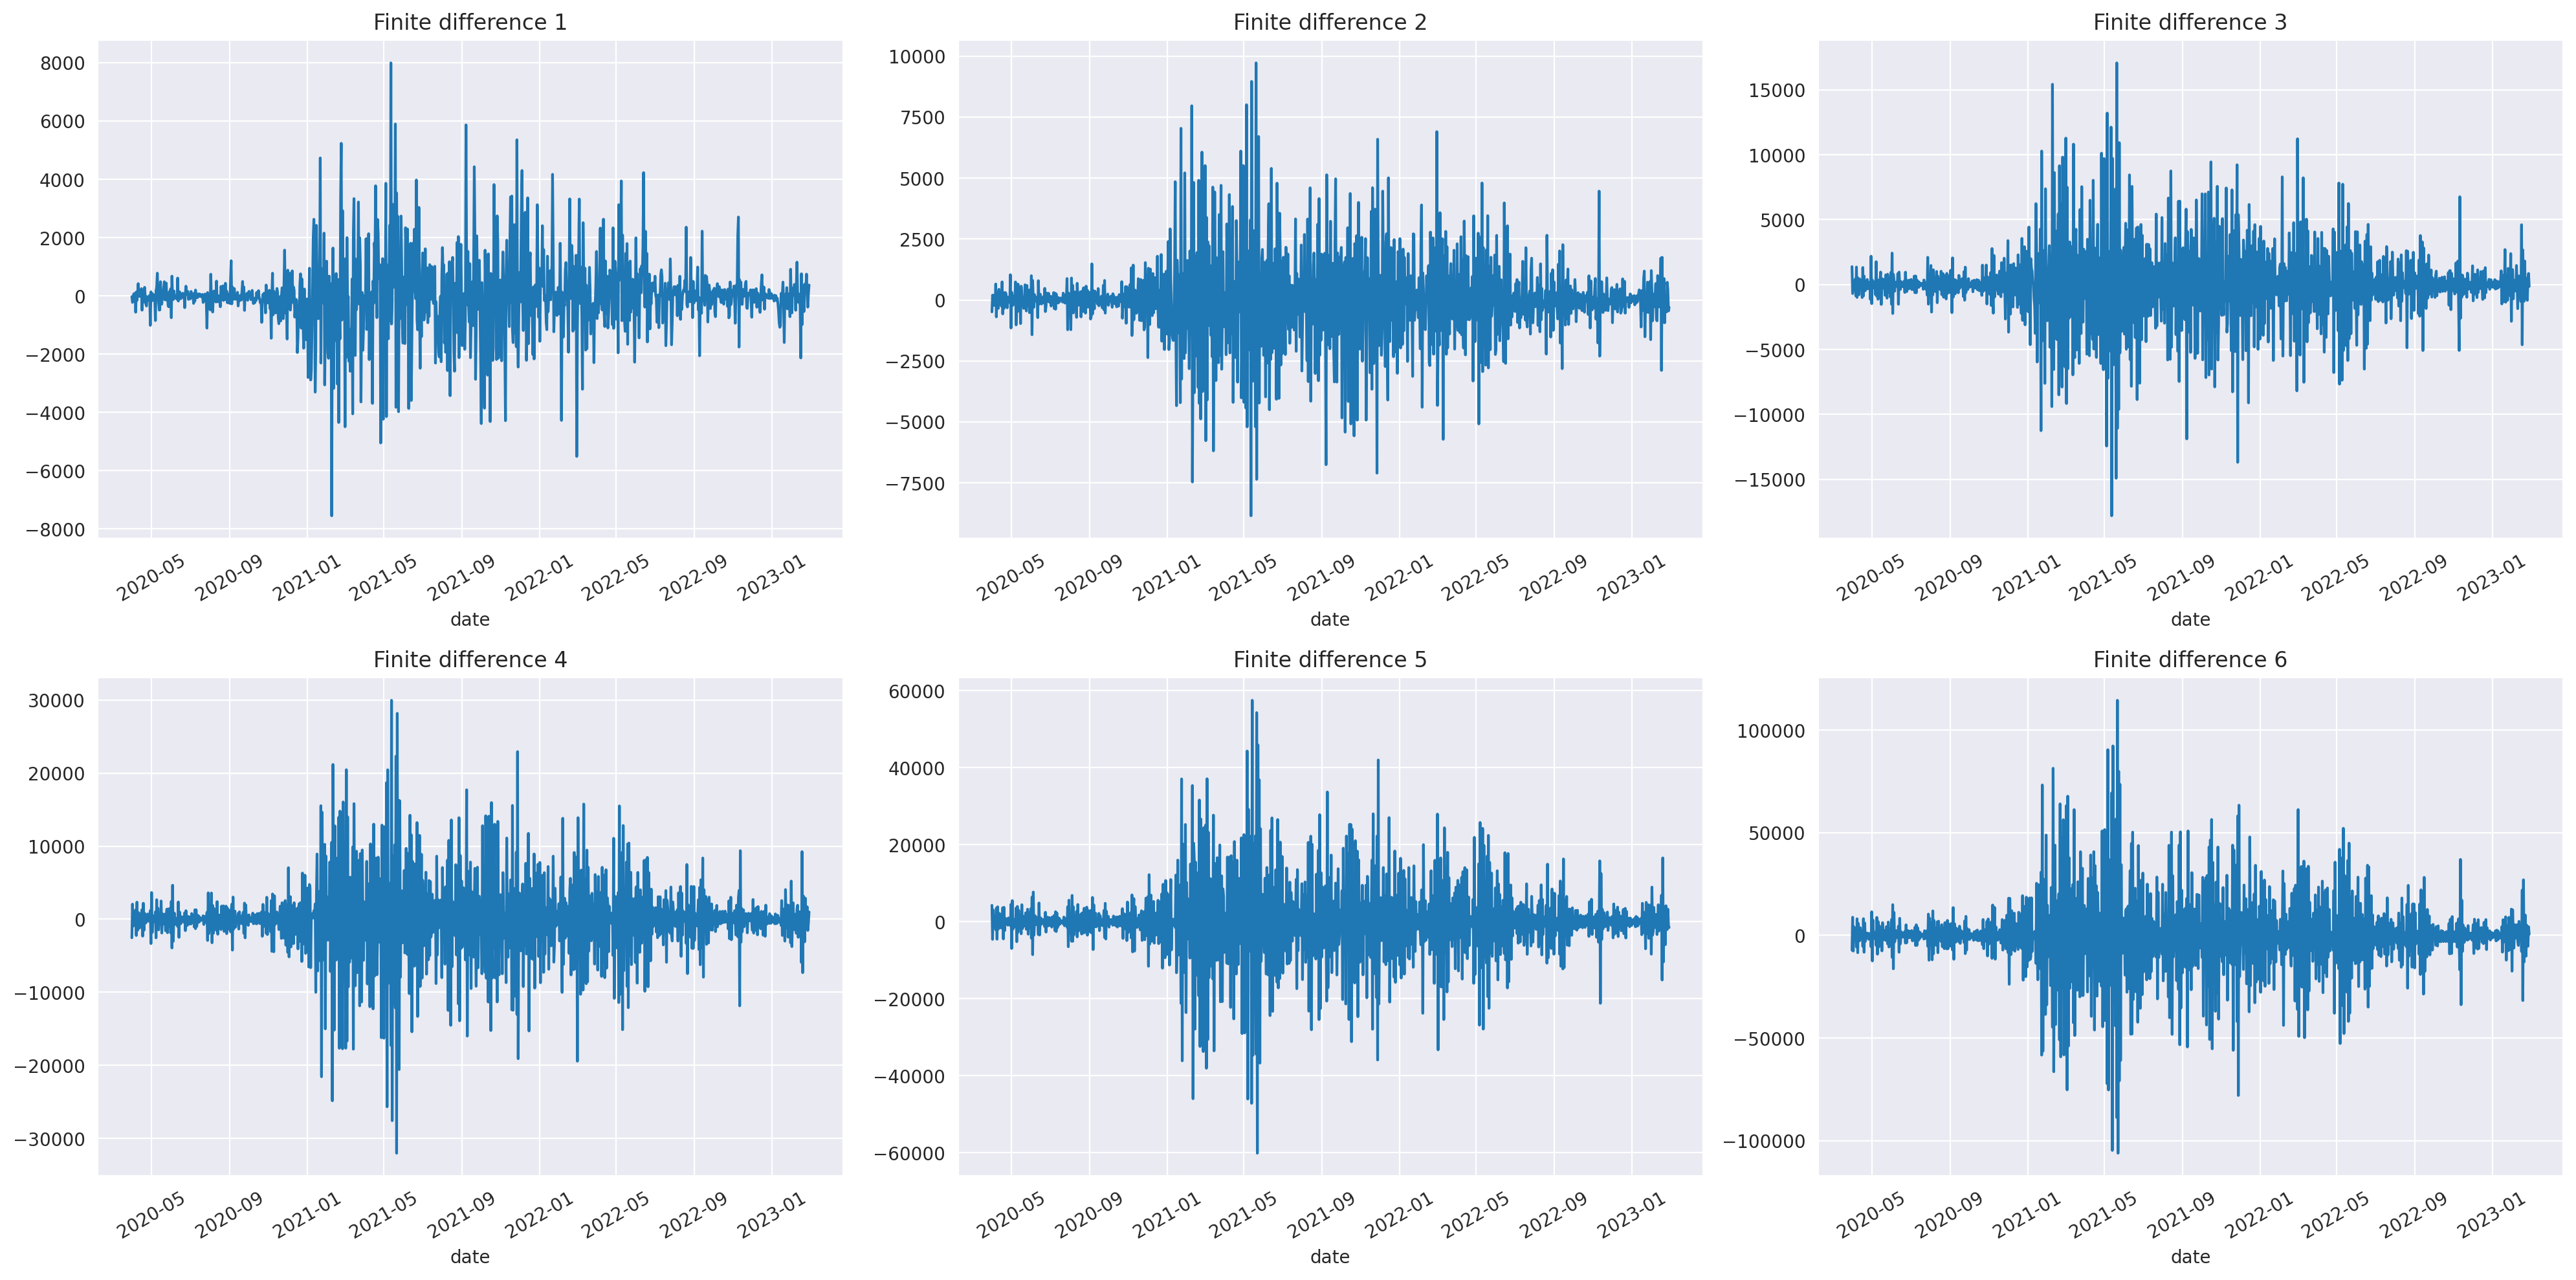

In [10]:
ndiffs = 6

diffs = pd.DataFrame(index=daily_prices.index) 
diff = daily_prices['open']
for idx in range(ndiffs):
    diff = (diff.shift(1) - diff).dropna()
    diffs[f'Finite difference {idx+1}'] = diff
diffs.dropna(inplace=True)

fig, axs = plt.subplots(nrows=2, ncols=ndiffs // 2, figsize=(20, 10))
for idx, col in enumerate(diffs.columns):
    ax = axs[idx // (ndiffs // 2)][idx % (ndiffs // 2)]
    diffs[col].plot(ax=ax, title=col, xlabel='date', rot=30)
    
fig.tight_layout()
plt.show()

# Log returns

<AxesSubplot: title={'center': 'log return series'}, xlabel='date'>

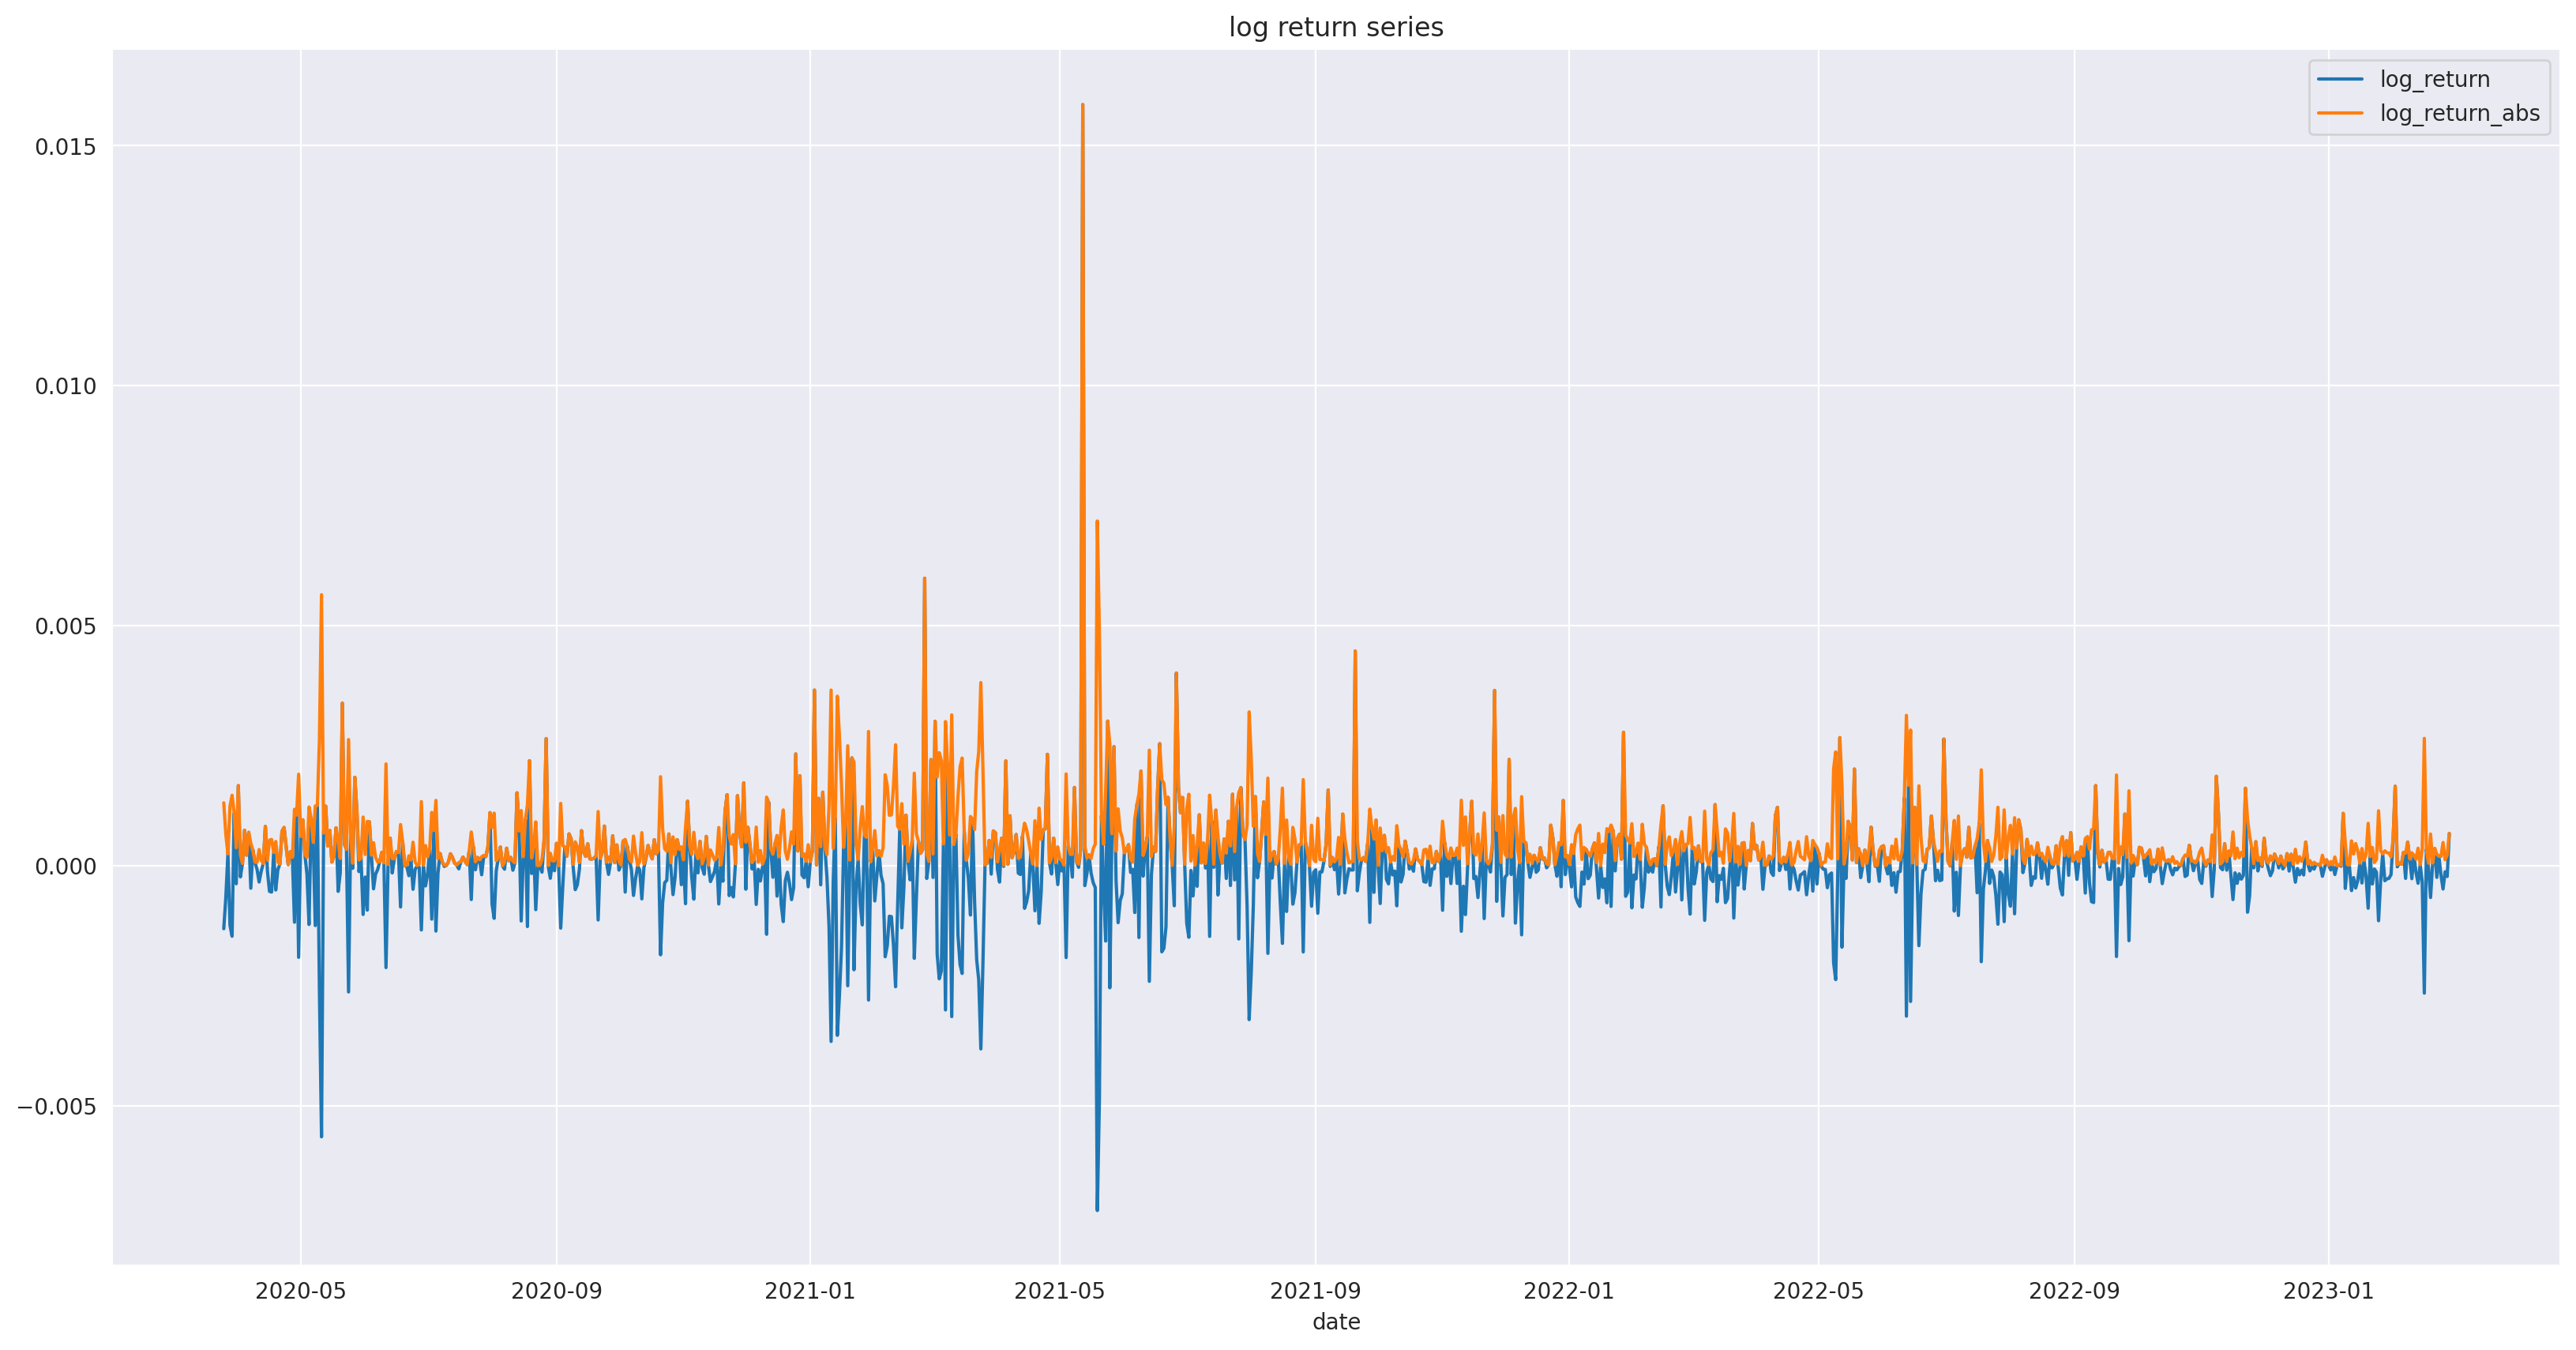

In [11]:
lr = pd.DataFrame(index=daily_prices.index)
lr['log_return'] = np.log(daily_prices['close'] / daily_prices['open'])
# lr = lr.groupby(lr.index.date).last()

lr['log_return_abs'] = np.abs(lr['log_return'])
lr['log_return_sign'] = np.sign(lr['log_return'])

lr[['log_return', 'log_return_abs']].plot(figsize=(20, 10), xlabel='date', title='log return series')

## autocorrelation

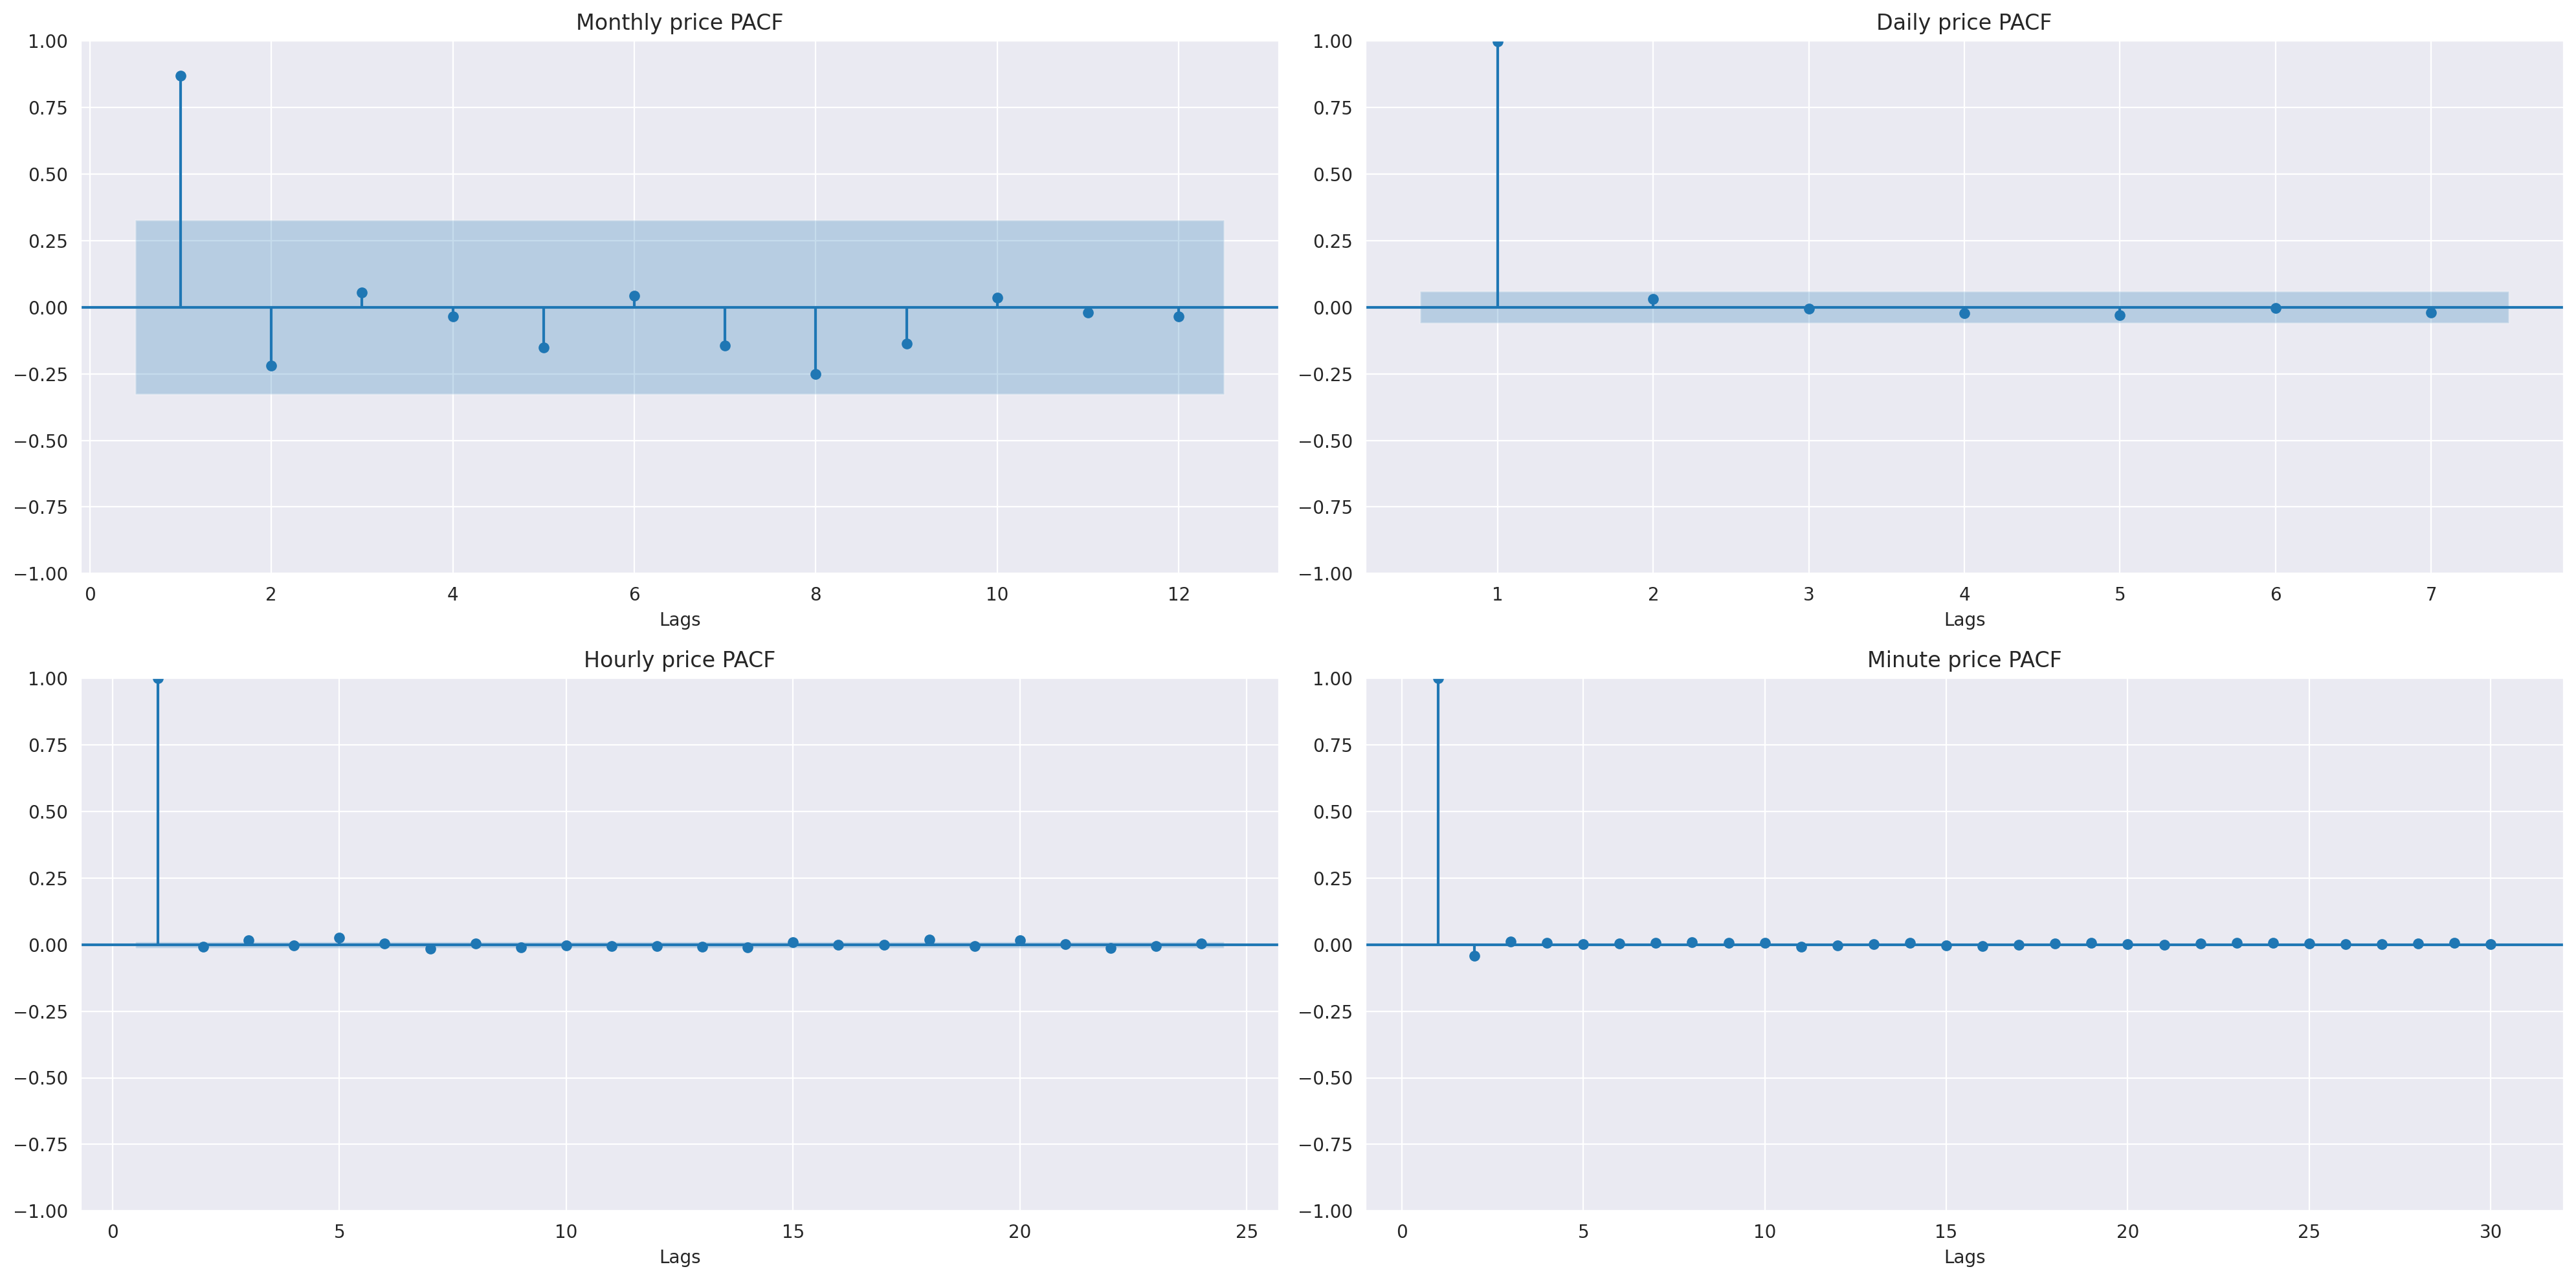

In [12]:
# Create figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

plot_pacf(price.groupby([price.index.year, price.index.month]).last(), lags=12, zero=False, ax=ax1, method='ywm')
ax1.set_title('Monthly price PACF')
ax1.set_xlabel('Lags')

plot_pacf(price.groupby([price.index.date]).last(), lags=7, zero=False, ax=ax2, method='ywm')
ax2.set_title('Daily price PACF')
ax2.set_xlabel('Lags')

plot_pacf(price.groupby([price.index.date, price.index.hour]).last(), lags=24, zero=False, ax=ax3, method='ywm')
ax3.set_title('Hourly price PACF')
ax3.set_xlabel('Lags')

plot_pacf(price.groupby([price.index.date, price.index.hour, price.index.minute]).last(), lags=30, zero=False, ax=ax4, method='ywm')
ax4.set_title('Minute price PACF')
ax4.set_xlabel('Lags')

# Display the plot
plt.tight_layout()
plt.show()

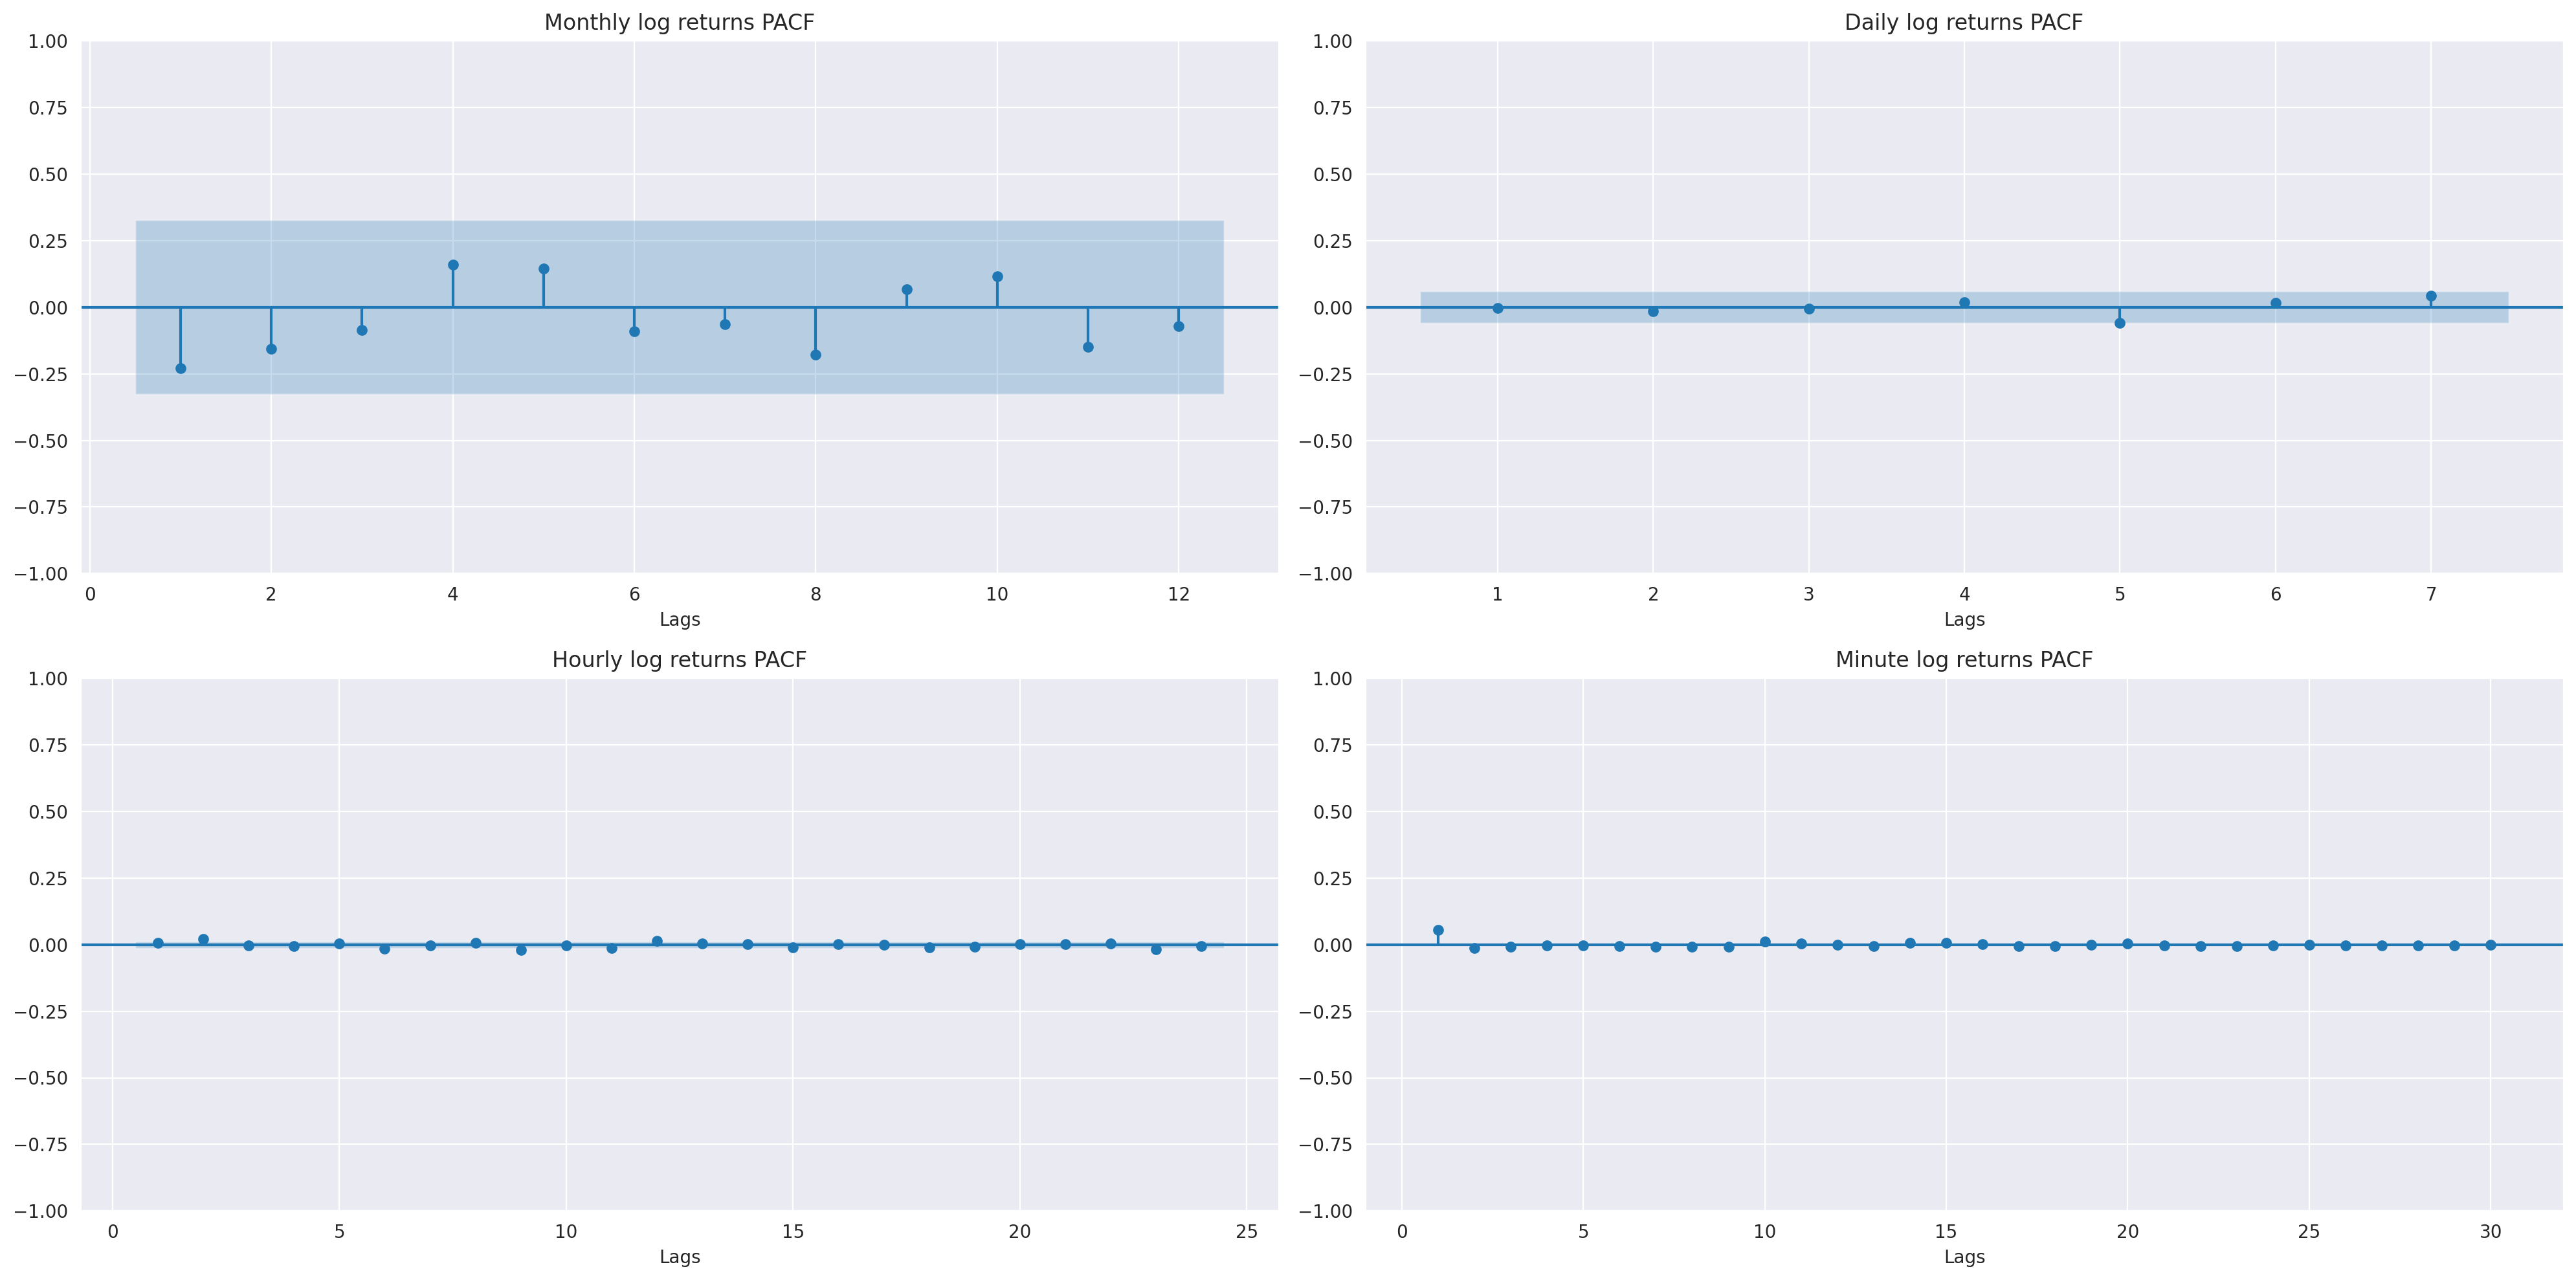

In [13]:
# Create figure and axes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

log_ret = np.log(price.shift(1) / price).dropna()

plot_pacf(log_ret.groupby([log_ret.index.year, log_ret.index.month]).last(), lags=12, zero=False, ax=ax1, method='ywm')
ax1.set_title('Monthly log returns PACF')
ax1.set_xlabel('Lags')

plot_pacf(log_ret.groupby([log_ret.index.date]).last(), lags=7, zero=False, ax=ax2, method='ywm')
ax2.set_title('Daily log returns PACF')
ax2.set_xlabel('Lags')

plot_pacf(log_ret.groupby([log_ret.index.date, log_ret.index.hour]).last(), lags=24, zero=False, ax=ax3, method='ywm')
ax3.set_title('Hourly log returns PACF')
ax3.set_xlabel('Lags')

plot_pacf(log_ret.groupby([log_ret.index.date, log_ret.index.hour, log_ret.index.minute]).last(), lags=30, zero=False, ax=ax4, method='ywm')
ax4.set_title('Minute log returns PACF')
ax4.set_xlabel('Lags')

# Display the plot
plt.tight_layout()
plt.show()

## GEV

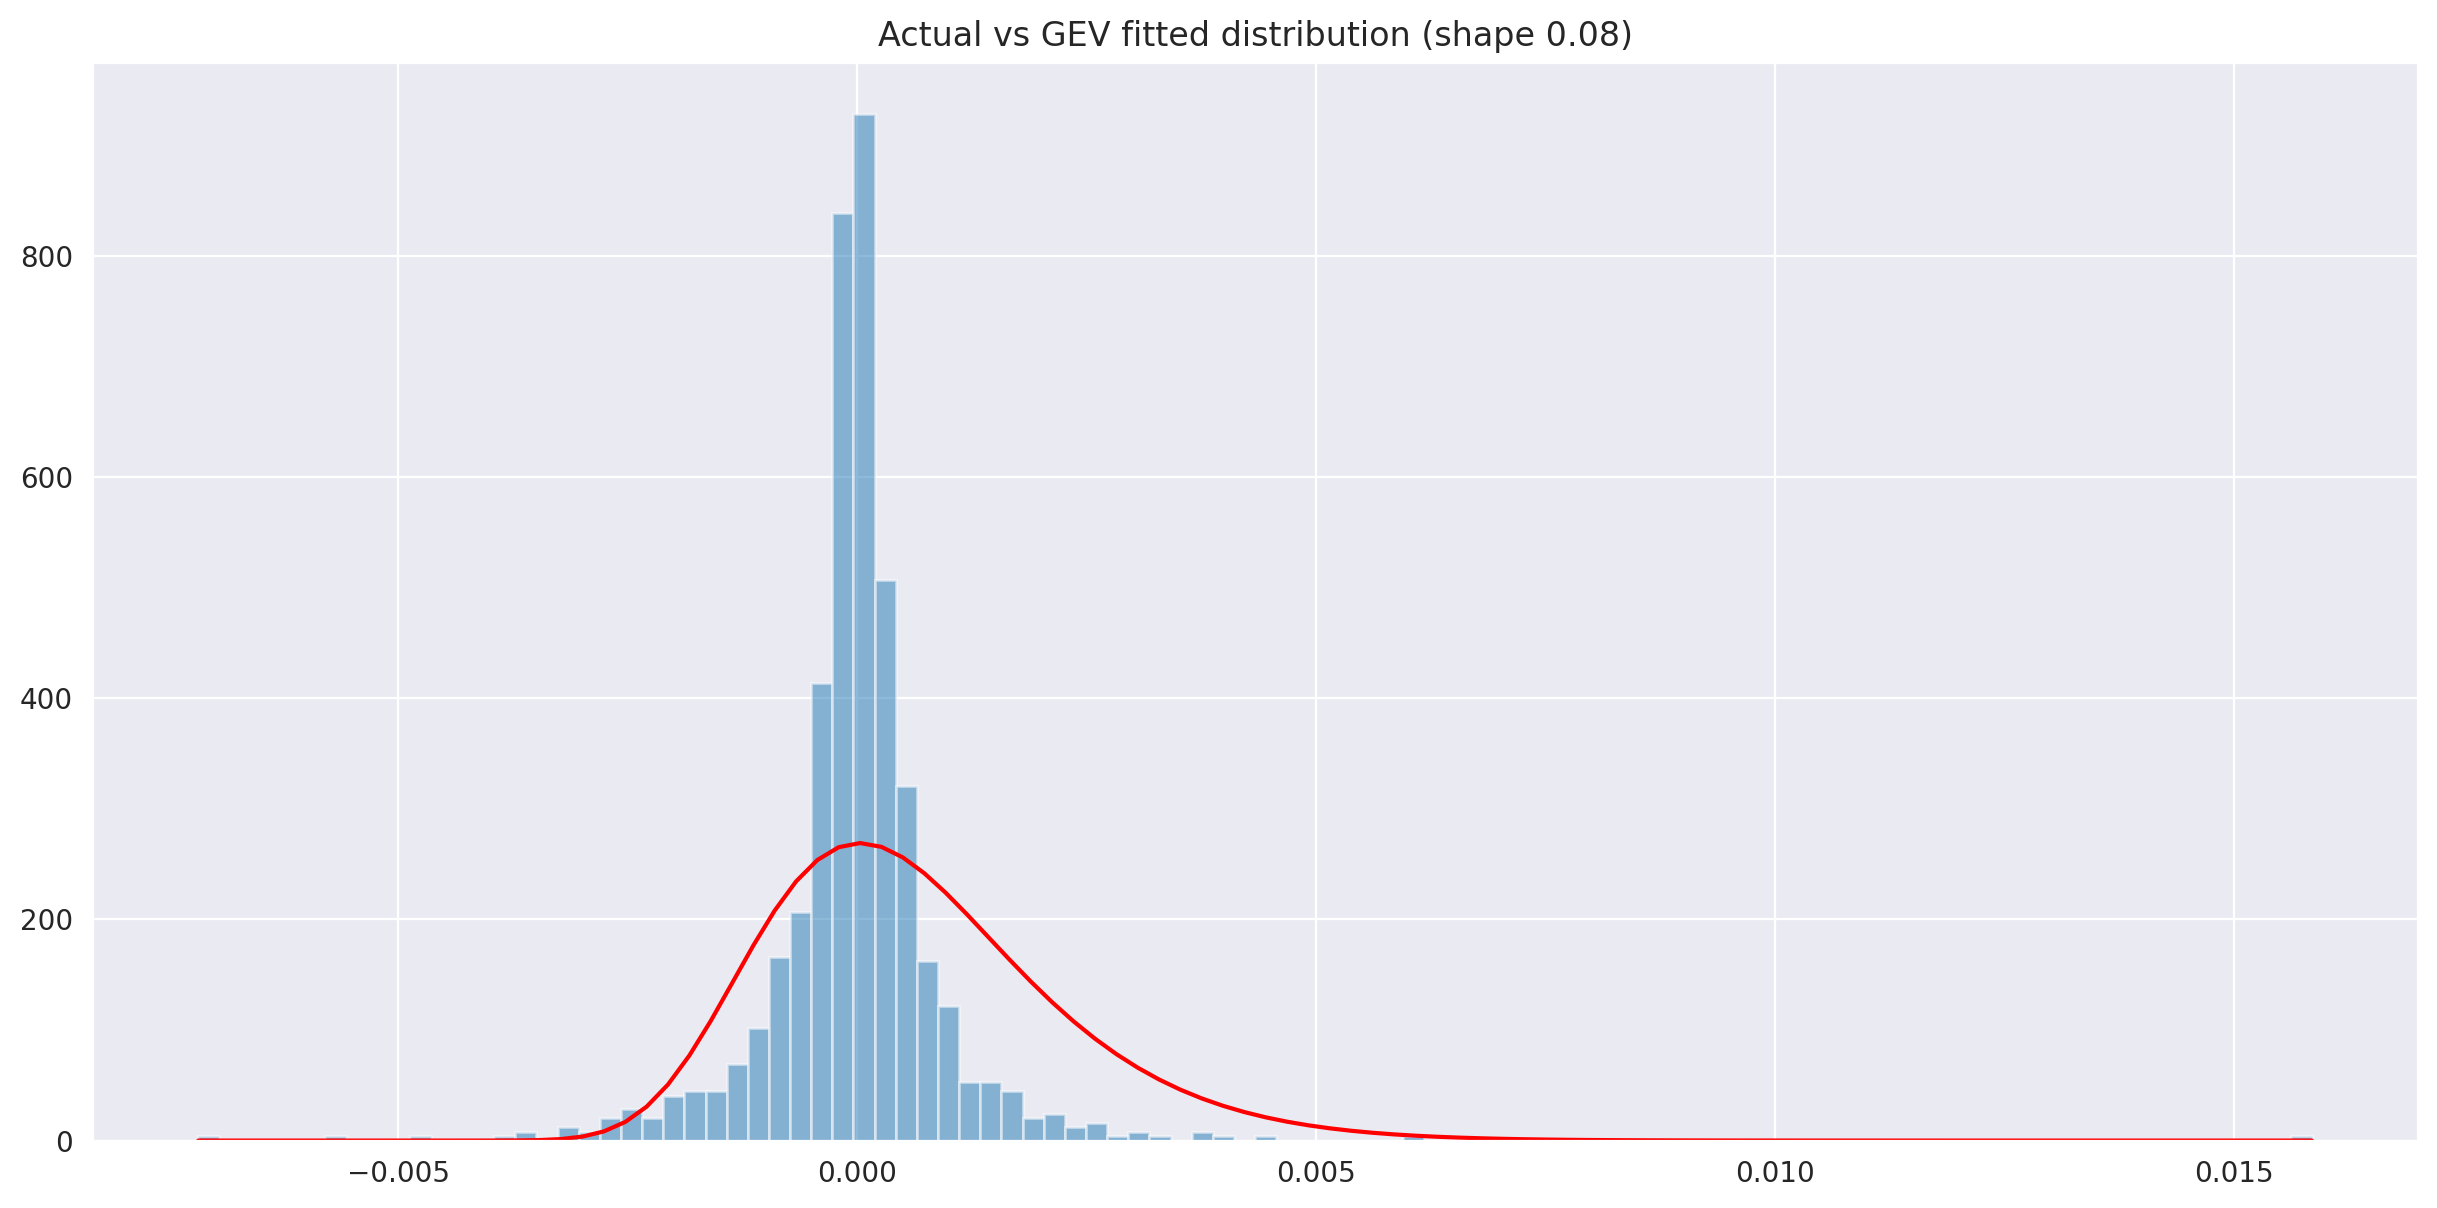

In [14]:
log_ret_daily = np.log(daily_prices['close'] / daily_prices['open']).dropna()
# Fit a GEV distribution to the returns
c, loc, scale = gev.fit(log_ret_daily)

fig = plt.figure(figsize=(15, 7))
# Plot the actual and fitted GEV distribution
plt.hist(log_ret_daily, bins=100, density=True, alpha=0.5)

x = np.linspace(min(log_ret_daily), max(log_ret_daily), 100)
pdf = gev.pdf(x, c, loc, scale)
plt.plot(x, pdf, 'r')

plt.title(f'Actual vs GEV fitted distribution (shape {c:.2f})')
plt.show()

# Tests

In [15]:
def stat_tests(series):
    keys = ['statistic', 'p_value']
    test_results = pd.DataFrame(index=pd.Index(keys, name=series.name))

    adf_test = adfuller(series)
    test_results['ADF non stationarity'] = pd.Series(data=adf_test[:2], index=keys)

    kpss_test = kpss(series)
    test_results['KPSS stationarity'] = pd.Series(kpss_test[:2], index=keys)
    
    bds_test = bds(series)
    test_results['BDS iid'] = pd.Series(bds_test[:2], index=keys)
    
    return test_results

In [16]:
display(stat_tests(daily_prices['open'].rename('price')))
display(stat_tests(lr['log_return']))
display(stat_tests(lr['log_return_abs']))
display(stat_tests(lr['log_return_sign']))
display(stat_tests(diffs[diffs.columns[0]]))

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF non stationarity  KPSS stationarity            BDS iid
price                                                                
statistic             -1.658065           1.241023  164.0269584569053
p_value                0.452838           0.010000                0.0

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


ADF non stationarity  KPSS stationarity                BDS iid
log_return                                                                
statistic          -1.212279e+01           0.029224      7.700699415990155
p_value             1.809100e-22           0.100000  1.353234738302674e-14

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF non stationarity  KPSS stationarity                BDS iid
log_return_abs                                                                
statistic              -6.621857e+00           1.333178      7.175714915422415
p_value                 6.009275e-09           0.010000  7.193030383288056e-13

ADF non stationarity  KPSS stationarity  \
log_return_sign                                            
statistic               -1.785713e+01           0.562130   
p_value                  3.063422e-30           0.027673   

                               BDS iid  
log_return_sign                         
statistic           -19.65357723125094  
p_value          5.387847315939619e-86

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


ADF non stationarity  KPSS stationarity  \
Finite difference 1                                            
statistic                       -33.94535           0.282042   
p_value                           0.00000           0.100000   

                                    BDS iid  
Finite difference 1                          
statistic                 4.726051042491993  
p_value              2.2892812746431473e-06

# Simple models

In [17]:
# interval = [price.index.date, price.index.hour]
grouped_price = price.resample('1h').last()
# grouped_price.index = grouped_price.index.map(lambda tp: tp[0] + pd.DateOffset(hours=tp[1]))
series = np.log(grouped_price.shift(1) / grouped_price).dropna()

norm = series.std()
series /= norm

window = 24
pred_len = window // 4
train_len = int(len(series) * 0.8)

train = series.values[:train_len]
test = series.values[train_len:]
val_series = series.iloc[train_len - 3 * window:train_len]
test_series = series.iloc[train_len: train_len + pred_len]

## SARIMAX

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47895D+00    |proj g|=  2.92270D-02

At iterate    5    f=  1.47691D+00    |proj g|=  5.65535D-04

At iterate   10    f=  1.47680D+00    |proj g|=  5.65029D-03

At iterate   15    f=  1.47670D+00    |proj g|=  4.11730D-04

At iterate   20    f=  1.47670D+00    |proj g|=  9.90682D-04

At iterate   25    f=  1.47667D+00    |proj g|=  5.70085D-04

At iterate   30    f=  1.47661D+00    |proj g|=  4.70684D-03

At iterate   35    f=  1.47645D+00    |proj g|=  1.48959D-02

At iterate   40    f=  1.47620D+00    |proj g|=  2.42541D-03

At iterate   45    f=  1.47614D+00    |proj g|=  2.11951D-03

At iterate   50    f=  1.47611D+00    |proj g|=  1.38022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


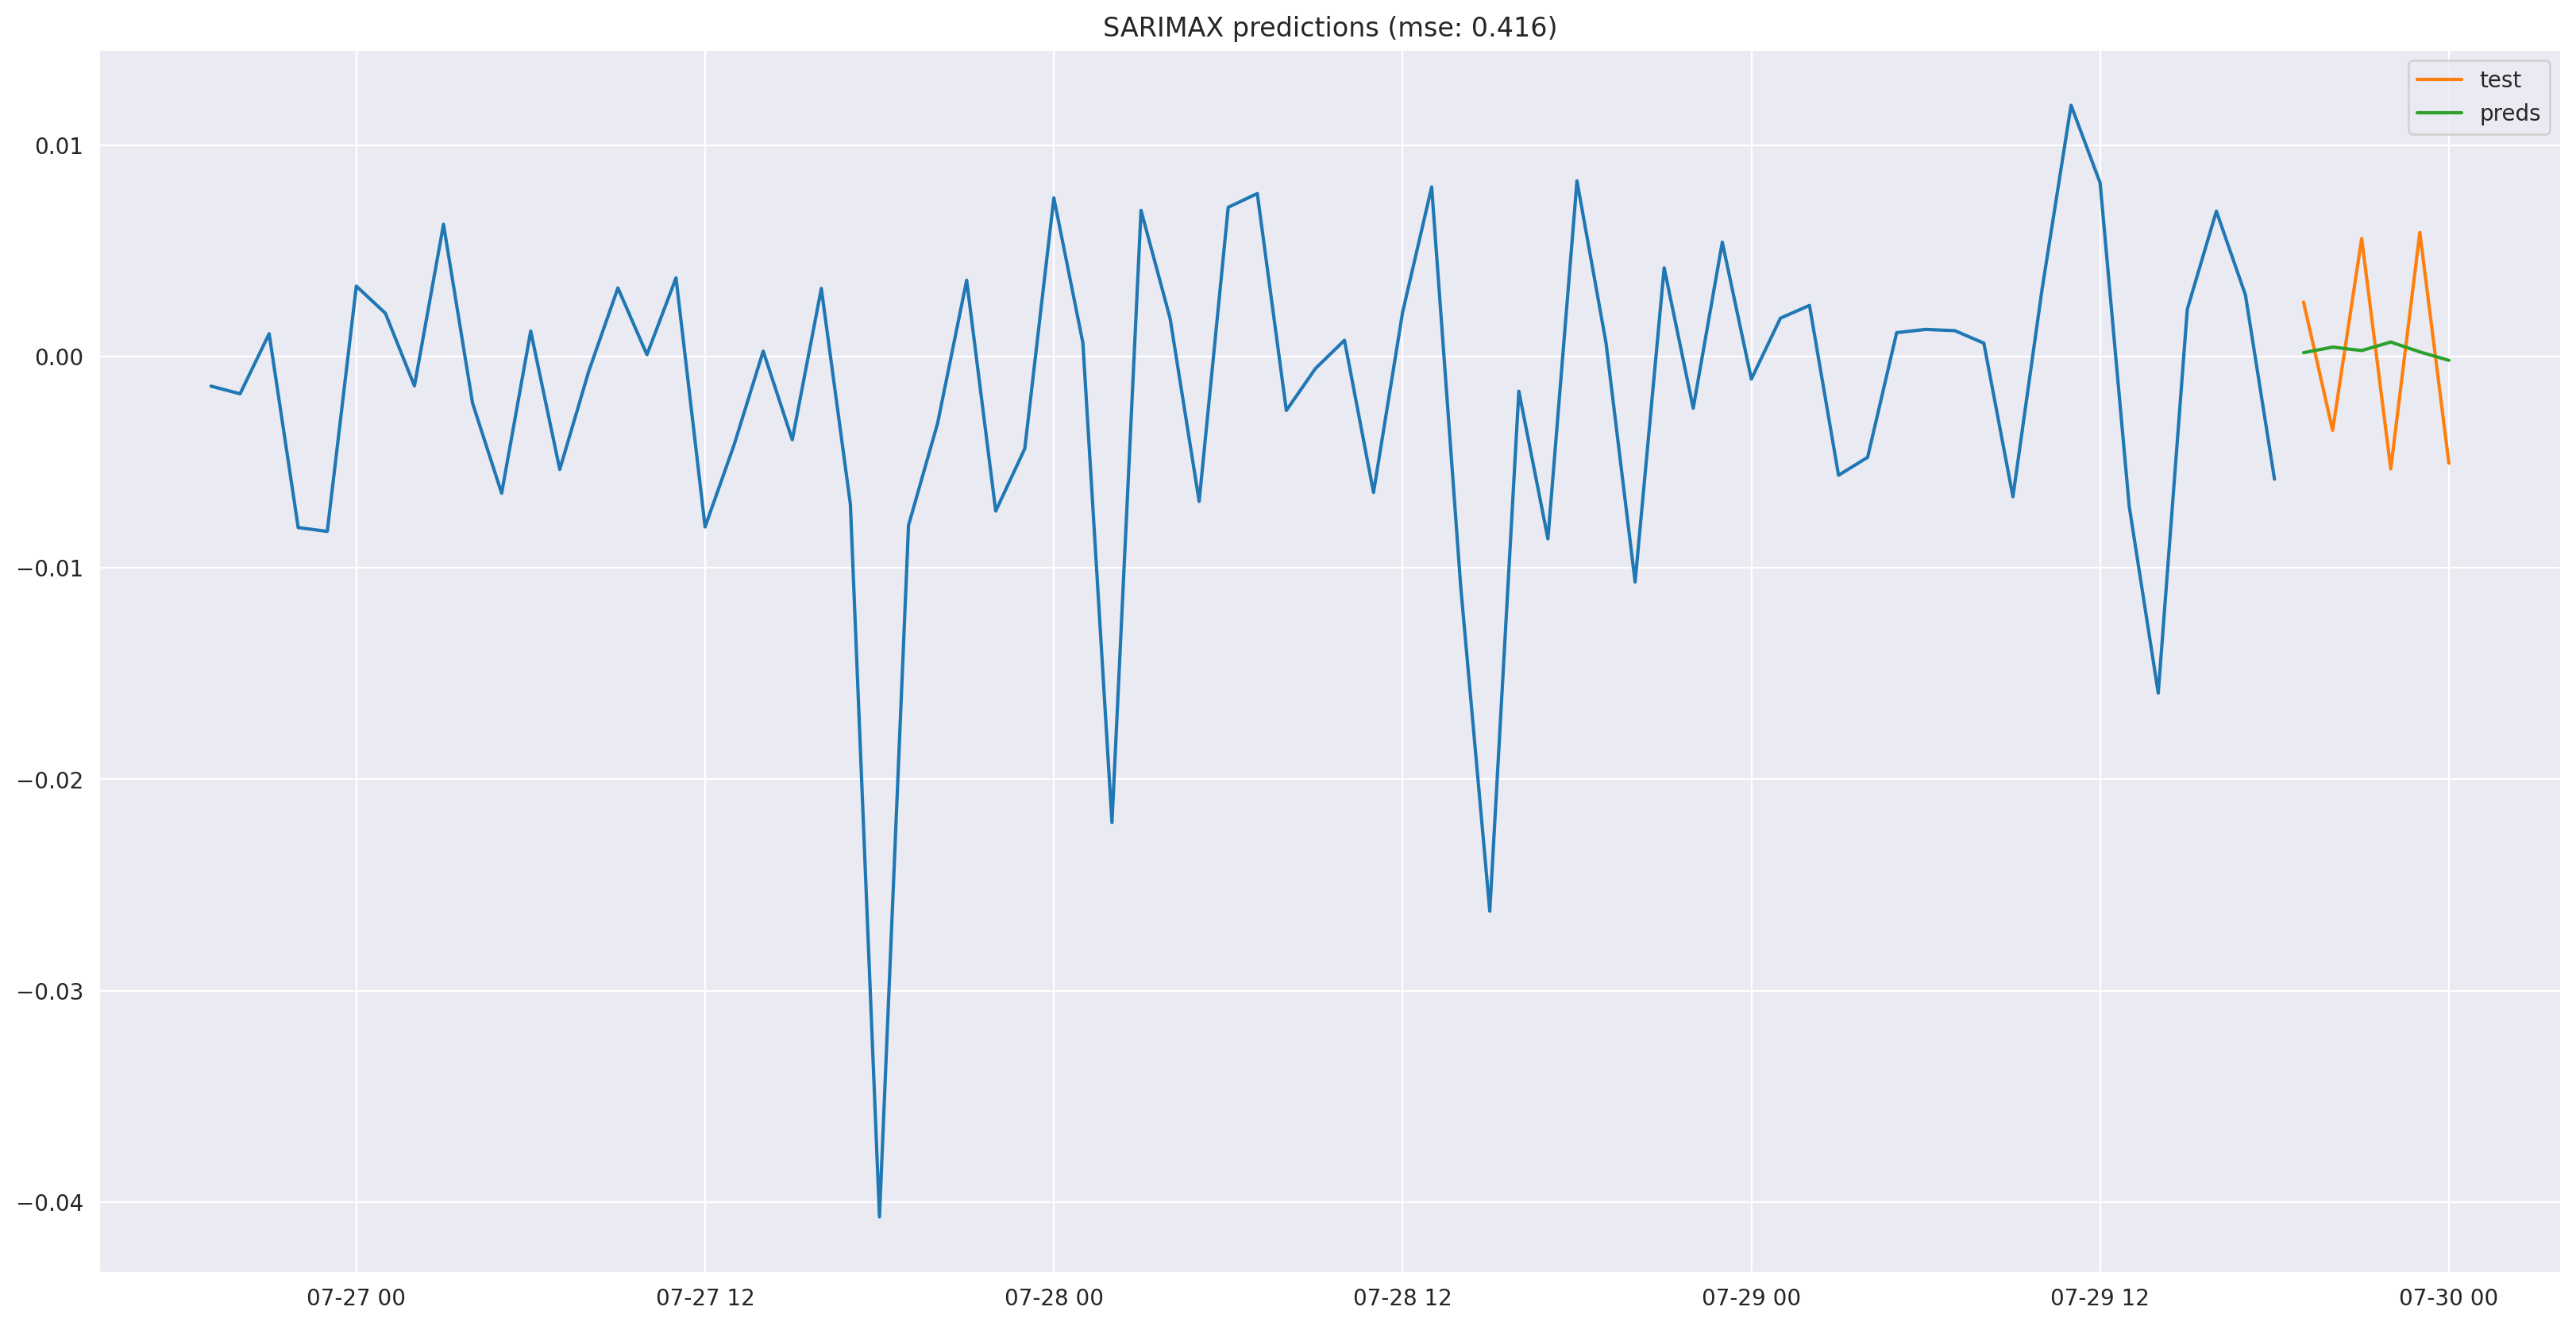

In [18]:
order = (window - pred_len, 0, 7)
# seasonal_order = (1, 0, 1, 7)  
sarimax = SARIMAX(endog=train, order=order)
model = sarimax.fit()

preds = model.predict(start=train_len, end=train_len + pred_len - 1)

fig = plt.figure(figsize=(20, 10))
plt.plot(val_series.index, val_series * norm)
plt.plot(test_series.index, test_series * norm, label='test')
plt.plot(test_series.index, preds * norm, label='preds')
plt.legend()
plt.title(f'SARIMAX predictions (mse: {((preds - test_series) ** 2).mean():.3f})')
plt.show()

# GARCH

Iteration:      1,   Func. Count:     23,   Neg. LLF: 129058.99394800051
Iteration:      2,   Func. Count:     49,   Neg. LLF: 5516916.424349811
Iteration:      3,   Func. Count:     72,   Neg. LLF: 288733.6741889068
Iteration:      4,   Func. Count:     95,   Neg. LLF: 30589.54243819503
Iteration:      5,   Func. Count:    120,   Neg. LLF: 37661.83293986242
Iteration:      6,   Func. Count:    144,   Neg. LLF: 36976.940984500514
Iteration:      7,   Func. Count:    168,   Neg. LLF: 34162.34613295792
Iteration:      8,   Func. Count:    192,   Neg. LLF: 31885.031262028722
Iteration:      9,   Func. Count:    216,   Neg. LLF: 30421.052506252385
Iteration:     10,   Func. Count:    240,   Neg. LLF: 35507.09553209519
Iteration:     11,   Func. Count:    264,   Neg. LLF: 29194.893098149172
Iteration:     12,   Func. Count:    287,   Neg. LLF: 29588.733695341496
Iteration:     13,   Func. Count:    311,   Neg. LLF: 28693.417555179665
Iteration:     14,   Func. Count:    334,   Neg. LLF: 291

/opt/conda/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


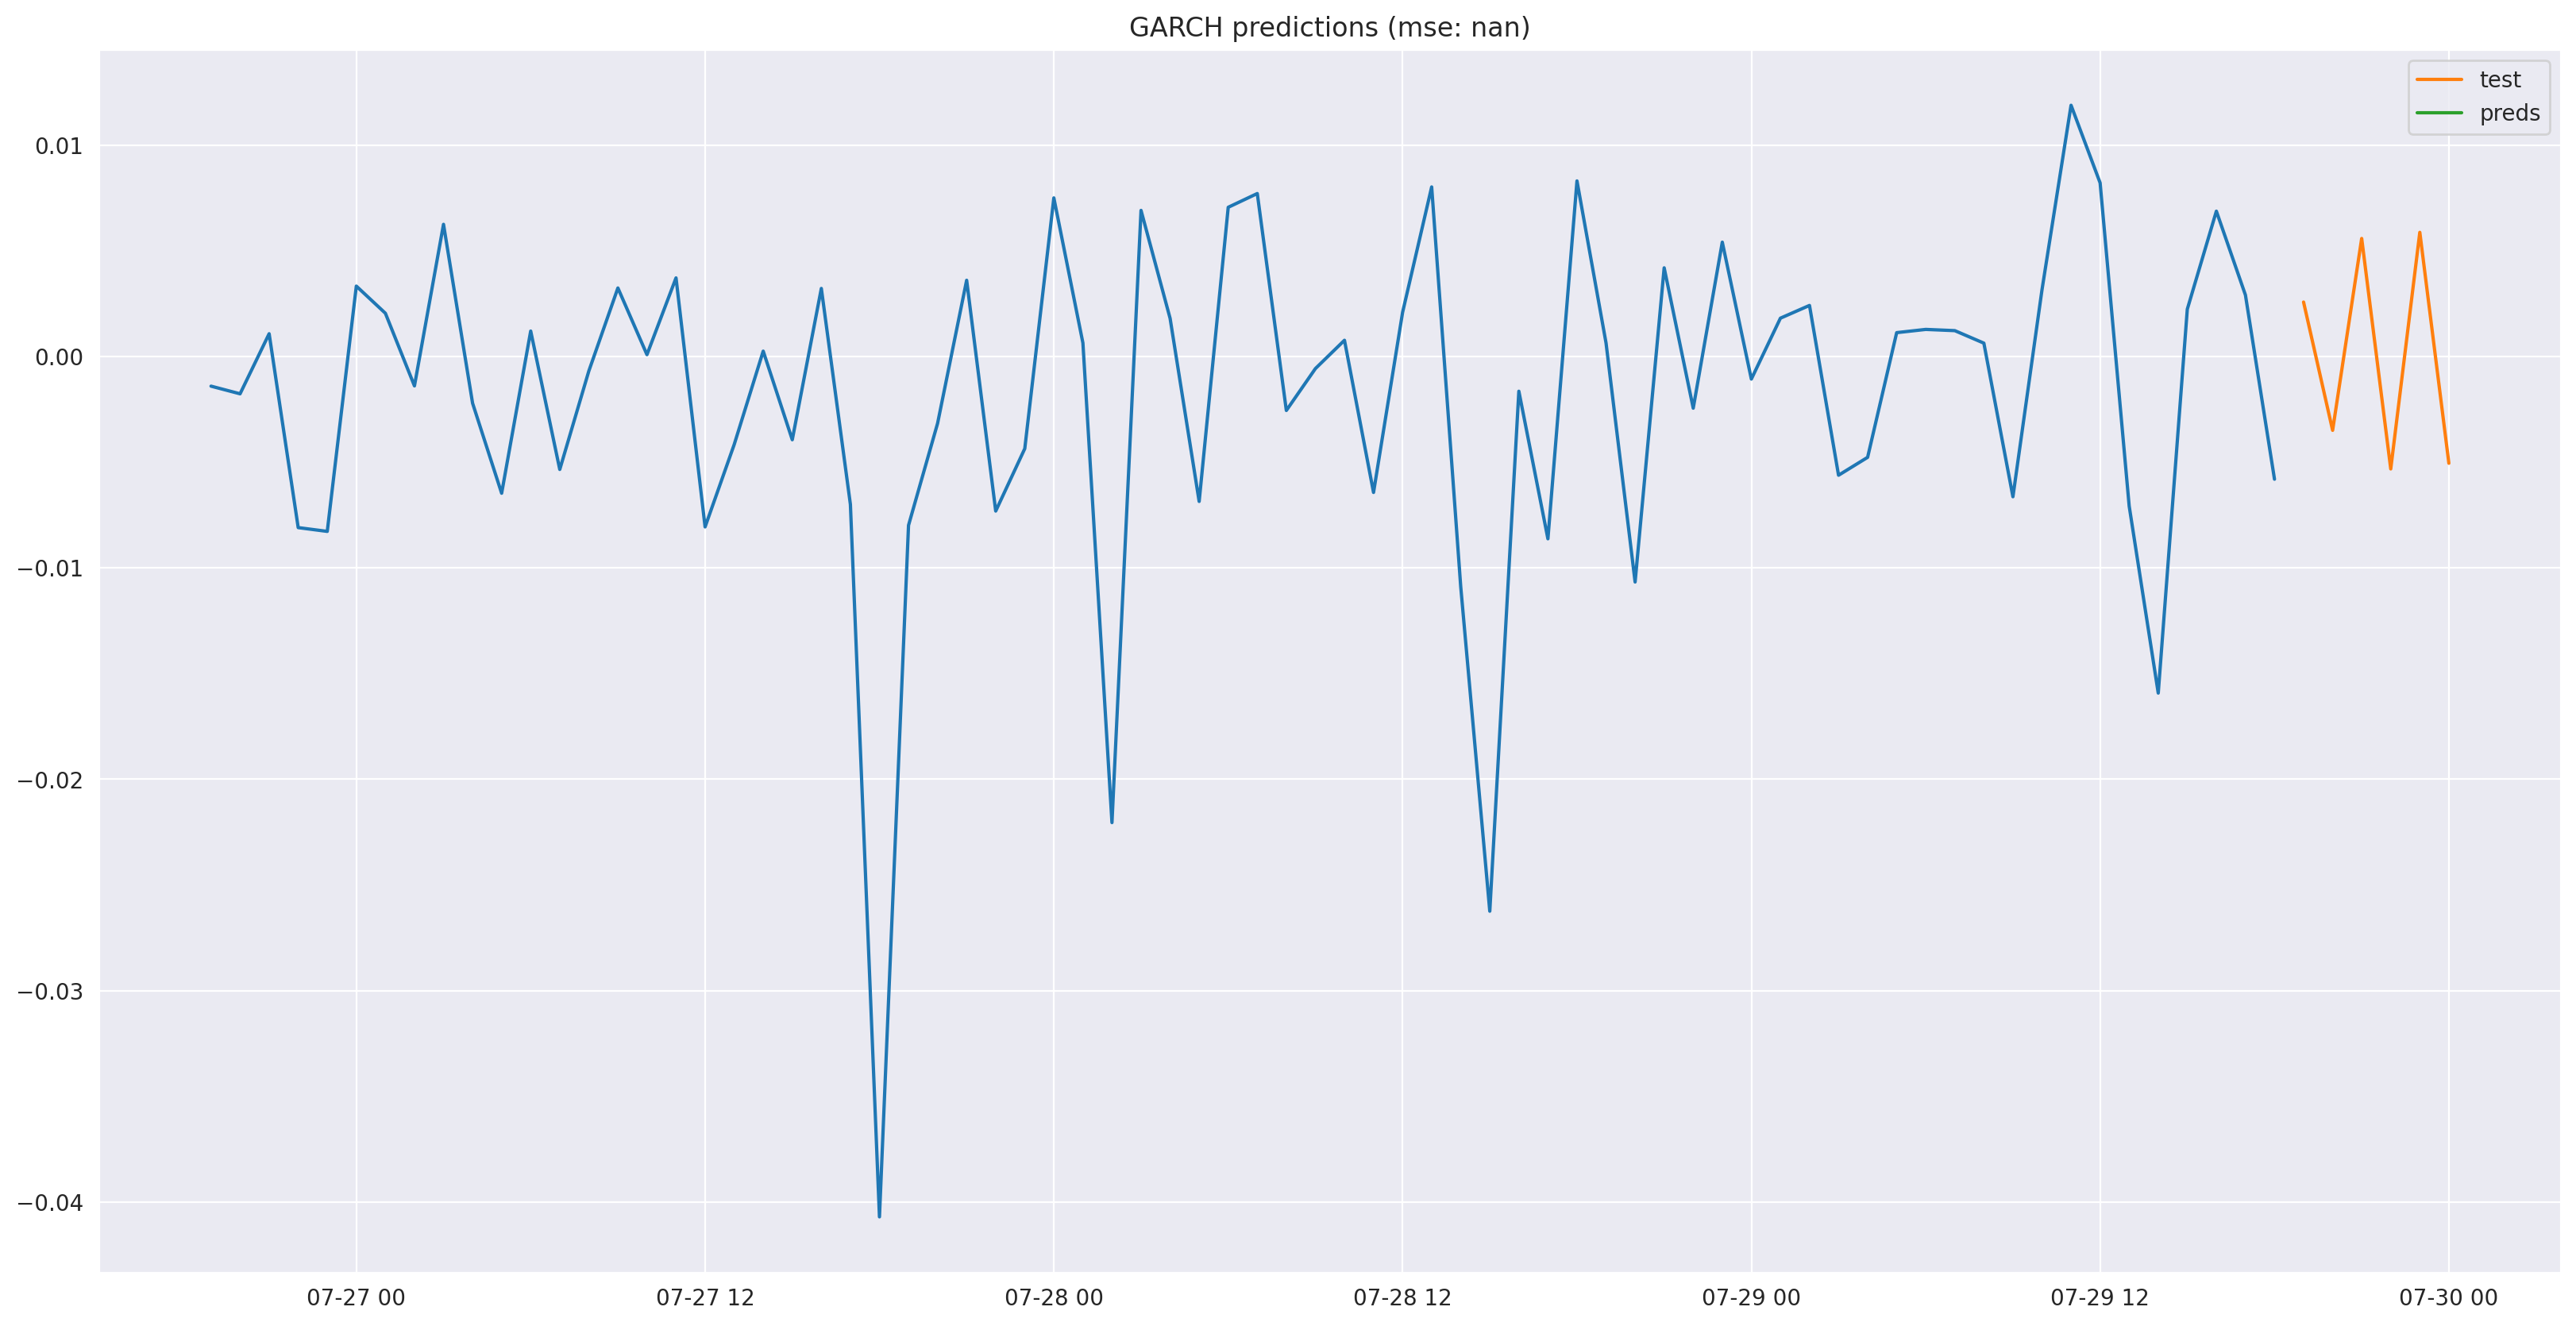

In [19]:
garch = arch_model(train, vol='Garch', p=window - pred_len, q=1)  
model = garch.fit(options={'maxiter': 300, 'ftol': 1e-3})

# Make predictions
result = model.forecast(start=len(train), horizon=pred_len)
preds = result.mean.iloc[-1:].values.flatten()
volatility = result.residual_variance.iloc[-1:].values.flatten()

fig = plt.figure(figsize=(20, 10))
plt.plot(val_series.index, val_series * norm)
plt.plot(test_series.index, test_series * norm, label='test')
plt.plot(test_series.index, preds * norm, label='preds')
plt.legend()
plt.title(f'GARCH predictions (mse: {((preds - test_series) ** 2).mean():.3f})')
plt.show()

## RNN

In [20]:
class BitcoinPriceDataset(torch.utils.data.Dataset):
    def __init__(self, prices, sequence_length):
        self.prices = prices
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.prices) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.prices[index : index + self.sequence_length], dtype=torch.float32),
            torch.tensor(self.prices[index + self.sequence_length], dtype=torch.float32),
        )
    
class SimpleGRU(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.input_mapper = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim * 4),
            torch.nn.Tanh(),
            torch.nn.Linear(hidden_dim * 4, hidden_dim),
            torch.nn.Tanh()
        )
        self.gru = torch.nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.gru(self.input_mapper(x.unsqueeze(-1)))
        return self.fc(output[:, -1])
    
# Prepare data
sequence_length = window - pred_len
batch_size = 512


dataloader = torch.utils.data.DataLoader(BitcoinPriceDataset(train, sequence_length), batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(BitcoinPriceDataset(test, sequence_length), batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize model
model = SimpleGRU(input_dim=1, hidden_dim=128, output_dim=1, num_layers=4).to(device)
# model = model.cuda()

# Loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# Training loop
total_epochs = 30
pbar = tqdm(range(total_epochs), desc='Training')
val_mse, best_mse = float('inf'), float('inf')
for epoch in pbar:
    model.train()
    for i, (x, y) in enumerate(dataloader):
        model.zero_grad(set_to_none=True)
#         x, y = x.cuda(), y.cuda()
        output = model(x.to(device))
        loss = torch.mean((output - y.to(device)) ** 2)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f'--- Epoch {epoch+1}/{total_epochs} [{i+1}/{len(dataloader)}] val_mse={val_mse:.4f} best_mse={best_mse:.4f}', refresh=True)
    scheduler.step()
    model.eval() 
    losses = []
    for i, (x, y) in enumerate(val_dataloader):
        preds = model(x.to(device))
        losses.append(torch.mean((preds - y.to(device)) ** 2))
        
    val_mse = torch.stack(losses).mean().item()
    best_mse = min(best_mse, val_mse)


--- Epoch 30/30 [41/41] val_mse=0.4697 best_mse=0.4697: 100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


Prediction: 100%|██████████| 6/6 [00:00<00:00, 570.61it/s]


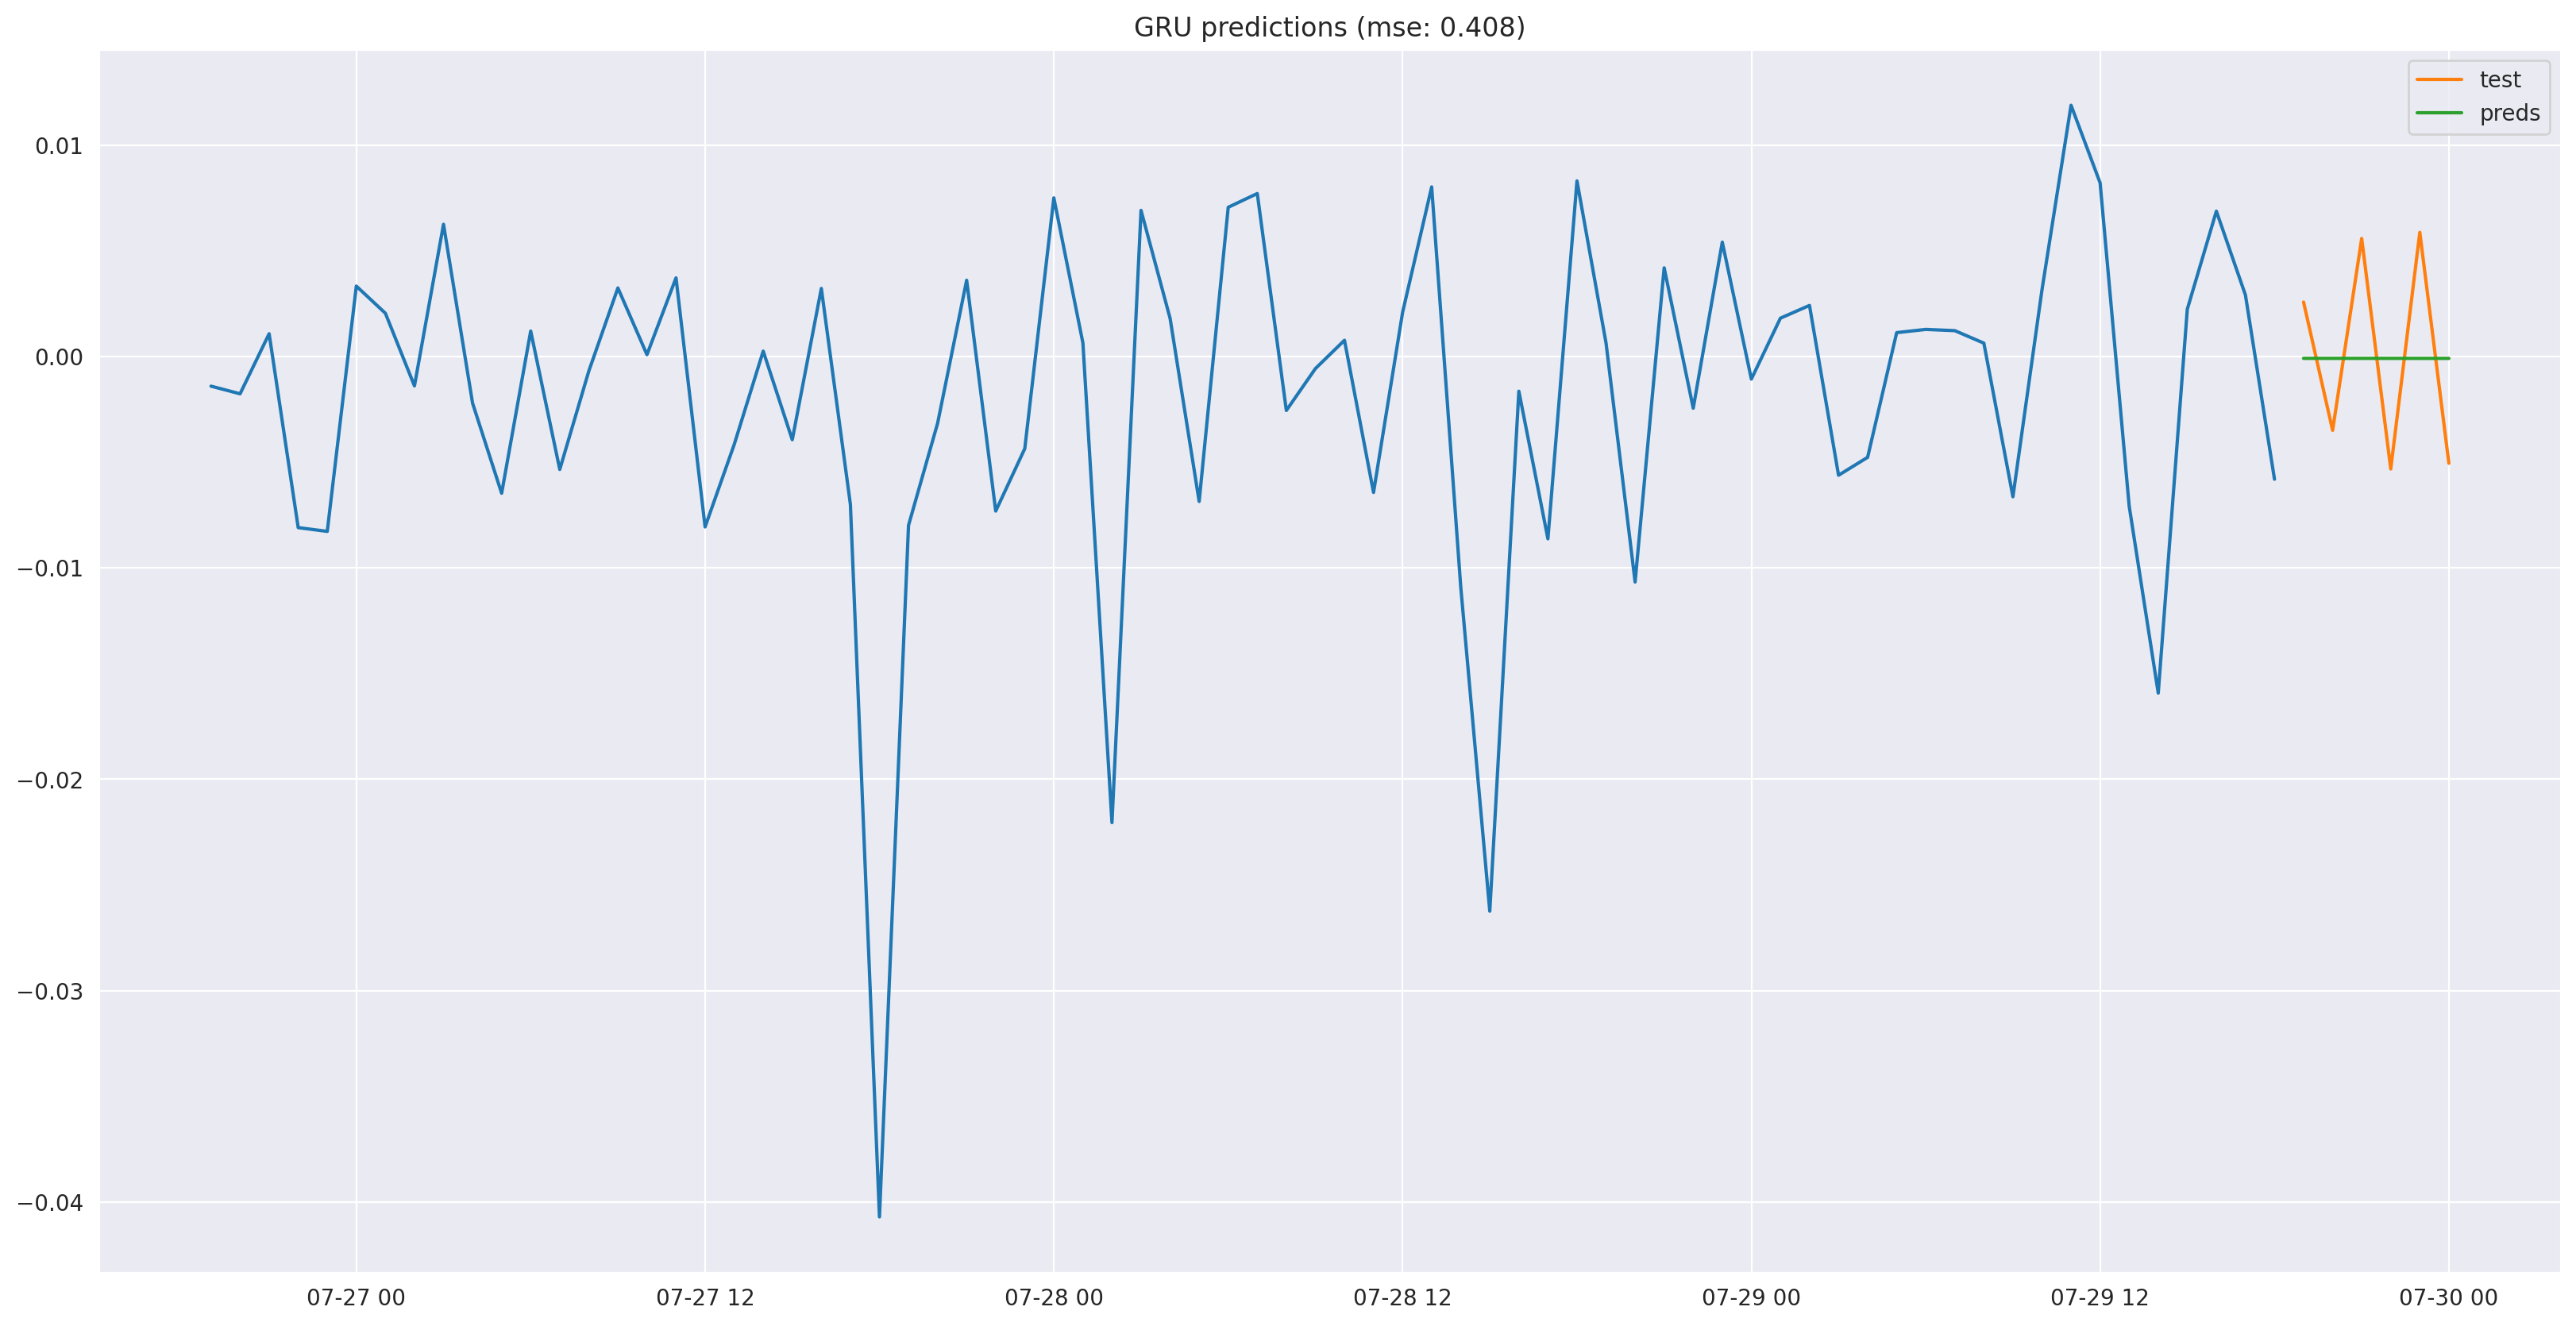

In [21]:
model.eval()
seq = torch.tensor(val_series.values[-sequence_length:], dtype=torch.float32, device=device).unsqueeze(0)
for time in tqdm(range(pred_len), desc='Prediction'):
    with torch.no_grad():
        pred = model(seq)
    seq = torch.cat([seq[:, 1:], pred], dim=1)
preds = seq[0, -pred_len:].detach().cpu().numpy()

fig = plt.figure(figsize=(20, 10))
plt.plot(val_series.index, val_series * norm)
plt.plot(test_series.index, test_series * norm, label='test')
plt.plot(test_series.index, preds * norm, label='preds')
plt.legend()
plt.title(f'GRU predictions (mse: {((preds - test_series) ** 2).mean():.3f})')
plt.show()

## Learn sequence distribution

In [22]:
class BitcoinPriceSequences(torch.utils.data.Dataset):
    def __init__(self, prices, sequence_length):
        self.prices = prices
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.prices) - self.sequence_length

    def __getitem__(self, index):
        return torch.tensor(self.prices[index : index + self.sequence_length], dtype=torch.float32)
    
    
class Attention(torch.nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads=8, head_dim=32, dropout=0., bias=False):
        super().__init__()
        if head_dim is not None:
            self.head_dim = head_dim
            self.num_heads = embed_dim // head_dim
        else:
            self.num_heads = num_heads
            self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.norm = torch.nn.LayerNorm(input_dim)
        self.to_q = torch.nn.Linear(input_dim, embed_dim, bias=bias)
        self.to_kv = torch.nn.Linear(input_dim, embed_dim * 2, bias=bias)
        self.to_out = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, input_dim, bias=bias),
            torch.nn.Dropout(dropout)
        )

    def forward(self, q, v=None, mask=None, **kwargs):
        # normalize inputs
        q_in = q
        q = self.norm(q)
        if v is None:
            v = q
        else:
            v = self.norm(v)

        # map inputs
        q = self.to_q(q)
        k, v = self.to_kv(v).chunk(2, dim=-1)

        b, n, dim = q.shape
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', d=self.head_dim), [q, k, v])
        q = q * self.scale

        dots = einsum(q, k, 'b h i d, b h j d -> b h i j')
        if mask is not None:
            if len(mask.shape) == 2:
                # masking paddings
                mask = mask.view(b, 1, 1, n)
            elif len(mask.shape) == 3:
                # masking sequence interconnections
                mask = mask.view(b, 1, n, n)
            dots = torch.where(mask, dots, torch.ones_like(dots) * float('-inf'))
        attn = torch.nn.functional.softmax(dots, dim=-1)
        out = torch.matmul(attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)

        return out + q_in    


    
class RNNGenerator(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, model_type='gru'):
        super().__init__()
        self.noise_mapper = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim * 4),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim * 4, hidden_dim),
            torch.nn.SiLU()
        )
        if model_type == 'gru':
            self.cond_processor = torch.nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
            self.noise_processor = torch.nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'lstm':
            self.cond_processor = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) 
            self.noise_processor = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True) 
        elif model_type == 'transformer':
            self.cond_processor = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim),
                                                      torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers))
            self.noise_processor = torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers)
    
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_dim, hidden_dim),
#             torch.nn.LayerNorm(hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
#             torch.nn.LayerNorm(hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, cond, noise):
        
        h_cond = self.cond_processor(cond.unsqueeze(-1))
        if isinstance(h_cond, tuple):
            h_cond = h_cond[0]
        h_cond = h_cond[:, -1:]
        
        h_noise = self.noise_processor(self.noise_mapper(noise.unsqueeze(-1)))
        if isinstance(h_noise, tuple):
            h_noise = h_noise[0]
        
        h = torch.cat([h_noise, h_cond.repeat(1, h_noise.shape[1], 1)], dim=-1)
        output = self.fc(h)
        return output.squeeze(-1)

class RNNDiscriminator(torch.nn.Module): 
    def __init__(self, input_dim, hidden_dim, num_layers, model_type='lstm'):
        super().__init__()
        self.input_mapper = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim)
        )
        if model_type == 'gru':
            self.seq_processor = torch.nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'lstm':
            self.seq_processor = torch.nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        elif model_type == 'transformer':
            self.seq_processor = torch.nn.TransformerEncoder(
                torch.nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, 
                                     activation=torch.nn.functional.silu, batch_first=True, norm_first=True), num_layers)
        self.fc = torch.nn.Sequential(torch.nn.utils.spectral_norm(torch.nn.Linear(hidden_dim, 1)))

    def forward(self, x):
        output = self.seq_processor(self.input_mapper(x.unsqueeze(-1)))
        if isinstance(output, tuple):
            output = output[0]
        output = self.fc(output[:, -1])
        return output.squeeze(-1)
    
def grad_norm(model):
    grads = [
        param.grad.detach().flatten()
        for param in model.parameters()
        if param.grad is not None
    ]
    norm = torch.cat(grads).norm()
    return norm

sequence_length = window
condition_size = window - pred_len

batch_size = 512
disc_warmup = 3

# Prepare data
dataloader = torch.utils.data.DataLoader(BitcoinPriceSequences(train, sequence_length), batch_size=batch_size, shuffle=True,
                                         pin_memory=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(BitcoinPriceSequences(test, sequence_length), batch_size=batch_size, shuffle=False,
                                            pin_memory=True, num_workers=2)

zero_loss = []
for i, real_sequence in enumerate(val_dataloader):
    target_sequences = real_sequence[:, condition_size:]
    zero_loss.append(torch.mean((target_sequences - 0) ** 2))
zero_loss = torch.stack(zero_loss).mean()
print(f'Mse loss of zero prediction --- {zero_loss:.4f}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize models
gen = RNNGenerator(1, 256, 1, 8, model_type='transformer').to(device)
disc = RNNDiscriminator(1, 128, 2, model_type='transformer').to(device)

# Loss function and optimizers
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=1e-3)
gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_optimizer, gamma=0.95)

disc_optimizer = torch.optim.SGD(disc.parameters(), lr=1e-4)
bce_fn = torch.nn.BCEWithLogitsLoss()

# Training loop
total_epochs = 30
epochs = tqdm(range(total_epochs), desc='Training')
val_mse = float('inf')
# Training loop
for epoch in epochs:
    gen.train()
    disc.train()
    for batch_id, real_sequences in enumerate(dataloader):
        real_sequences = real_sequences.to(device)
        
        # update generator
        gen_optimizer.zero_grad(set_to_none=True)
                
        condition = real_sequences[:, :condition_size]
        target_sequences = real_sequences[:, condition_size:]
        pred_sequences = gen(condition, torch.randn_like(target_sequences))
        pred_std = pred_sequences.std().item()
        
        gen_mse = torch.mean((target_sequences - pred_sequences) ** 2)
        gen_loss = gen_mse
        if epoch >= disc_warmup:
            gen_loss = gen_loss * 1.0
        
        adv_loss = torch.tensor(0)
        if epoch >= disc_warmup:
            disc_logits = disc(pred_sequences)
            adv_loss = bce_fn(disc_logits, torch.ones_like(disc_logits))
            gen_loss += adv_loss * 1.0
        
        gen_loss.backward()
        model_grad_norm = grad_norm(gen)
        
        gen_optimizer.step()
        
        # Undate discriminator
        disc_optimizer.zero_grad(set_to_none=True)
        
        disc_preds = disc(torch.cat([target_sequences, pred_sequences.detach()], dim=0))
        disc_targets = torch.cat([torch.ones(len(target_sequences)), torch.zeros(len(pred_sequences))], dim=0).type_as(disc_preds)
        
        disc_loss = bce_fn(disc_preds, disc_targets)
        
        disc_loss.backward()
        disc_optimizer.step()
        
        epochs.set_description(f'--- Epoch {epoch+1}/{total_epochs} [{batch_id+1}/{len(dataloader)}] gen_loss={gen_loss.item():.4f} gen_mse={gen_mse.item():.4f} gen_adv={adv_loss.item():.4f} disc_loss={disc_loss.item():.4f} pred_std={pred_std:.4f} val_mse={val_mse:.4f} grad_norm={model_grad_norm.item():.4f}', refresh=True)
        
    gen_scheduler.step()
    
    gen.eval()
    disc.eval()
    losses = []
    for i, real_sequence in enumerate(val_dataloader):
        real_sequences = real_sequences.to(device)
        condition = real_sequences[:, :condition_size]
        target_sequences = real_sequences[:, condition_size:]
        pred_sequences = gen(condition, torch.randn_like(target_sequences))
        losses.append(torch.mean((target_sequences - pred_sequences) ** 2))
        
    val_mse = torch.stack(losses).mean().item()
    
    

Mse loss of zero prediction --- 0.4903


--- Epoch 30/30 [41/41] gen_loss=1.7143 gen_mse=0.8853 gen_adv=0.8291 disc_loss=0.6457 pred_std=0.0300 val_mse=1.0141 grad_norm=0.1861: 100%|██████████| 30/30 [03:17<00:00,  6.58s/it]


Simulation: 100%|██████████| 1/1 [00:00<00:00, 95.24it/s]


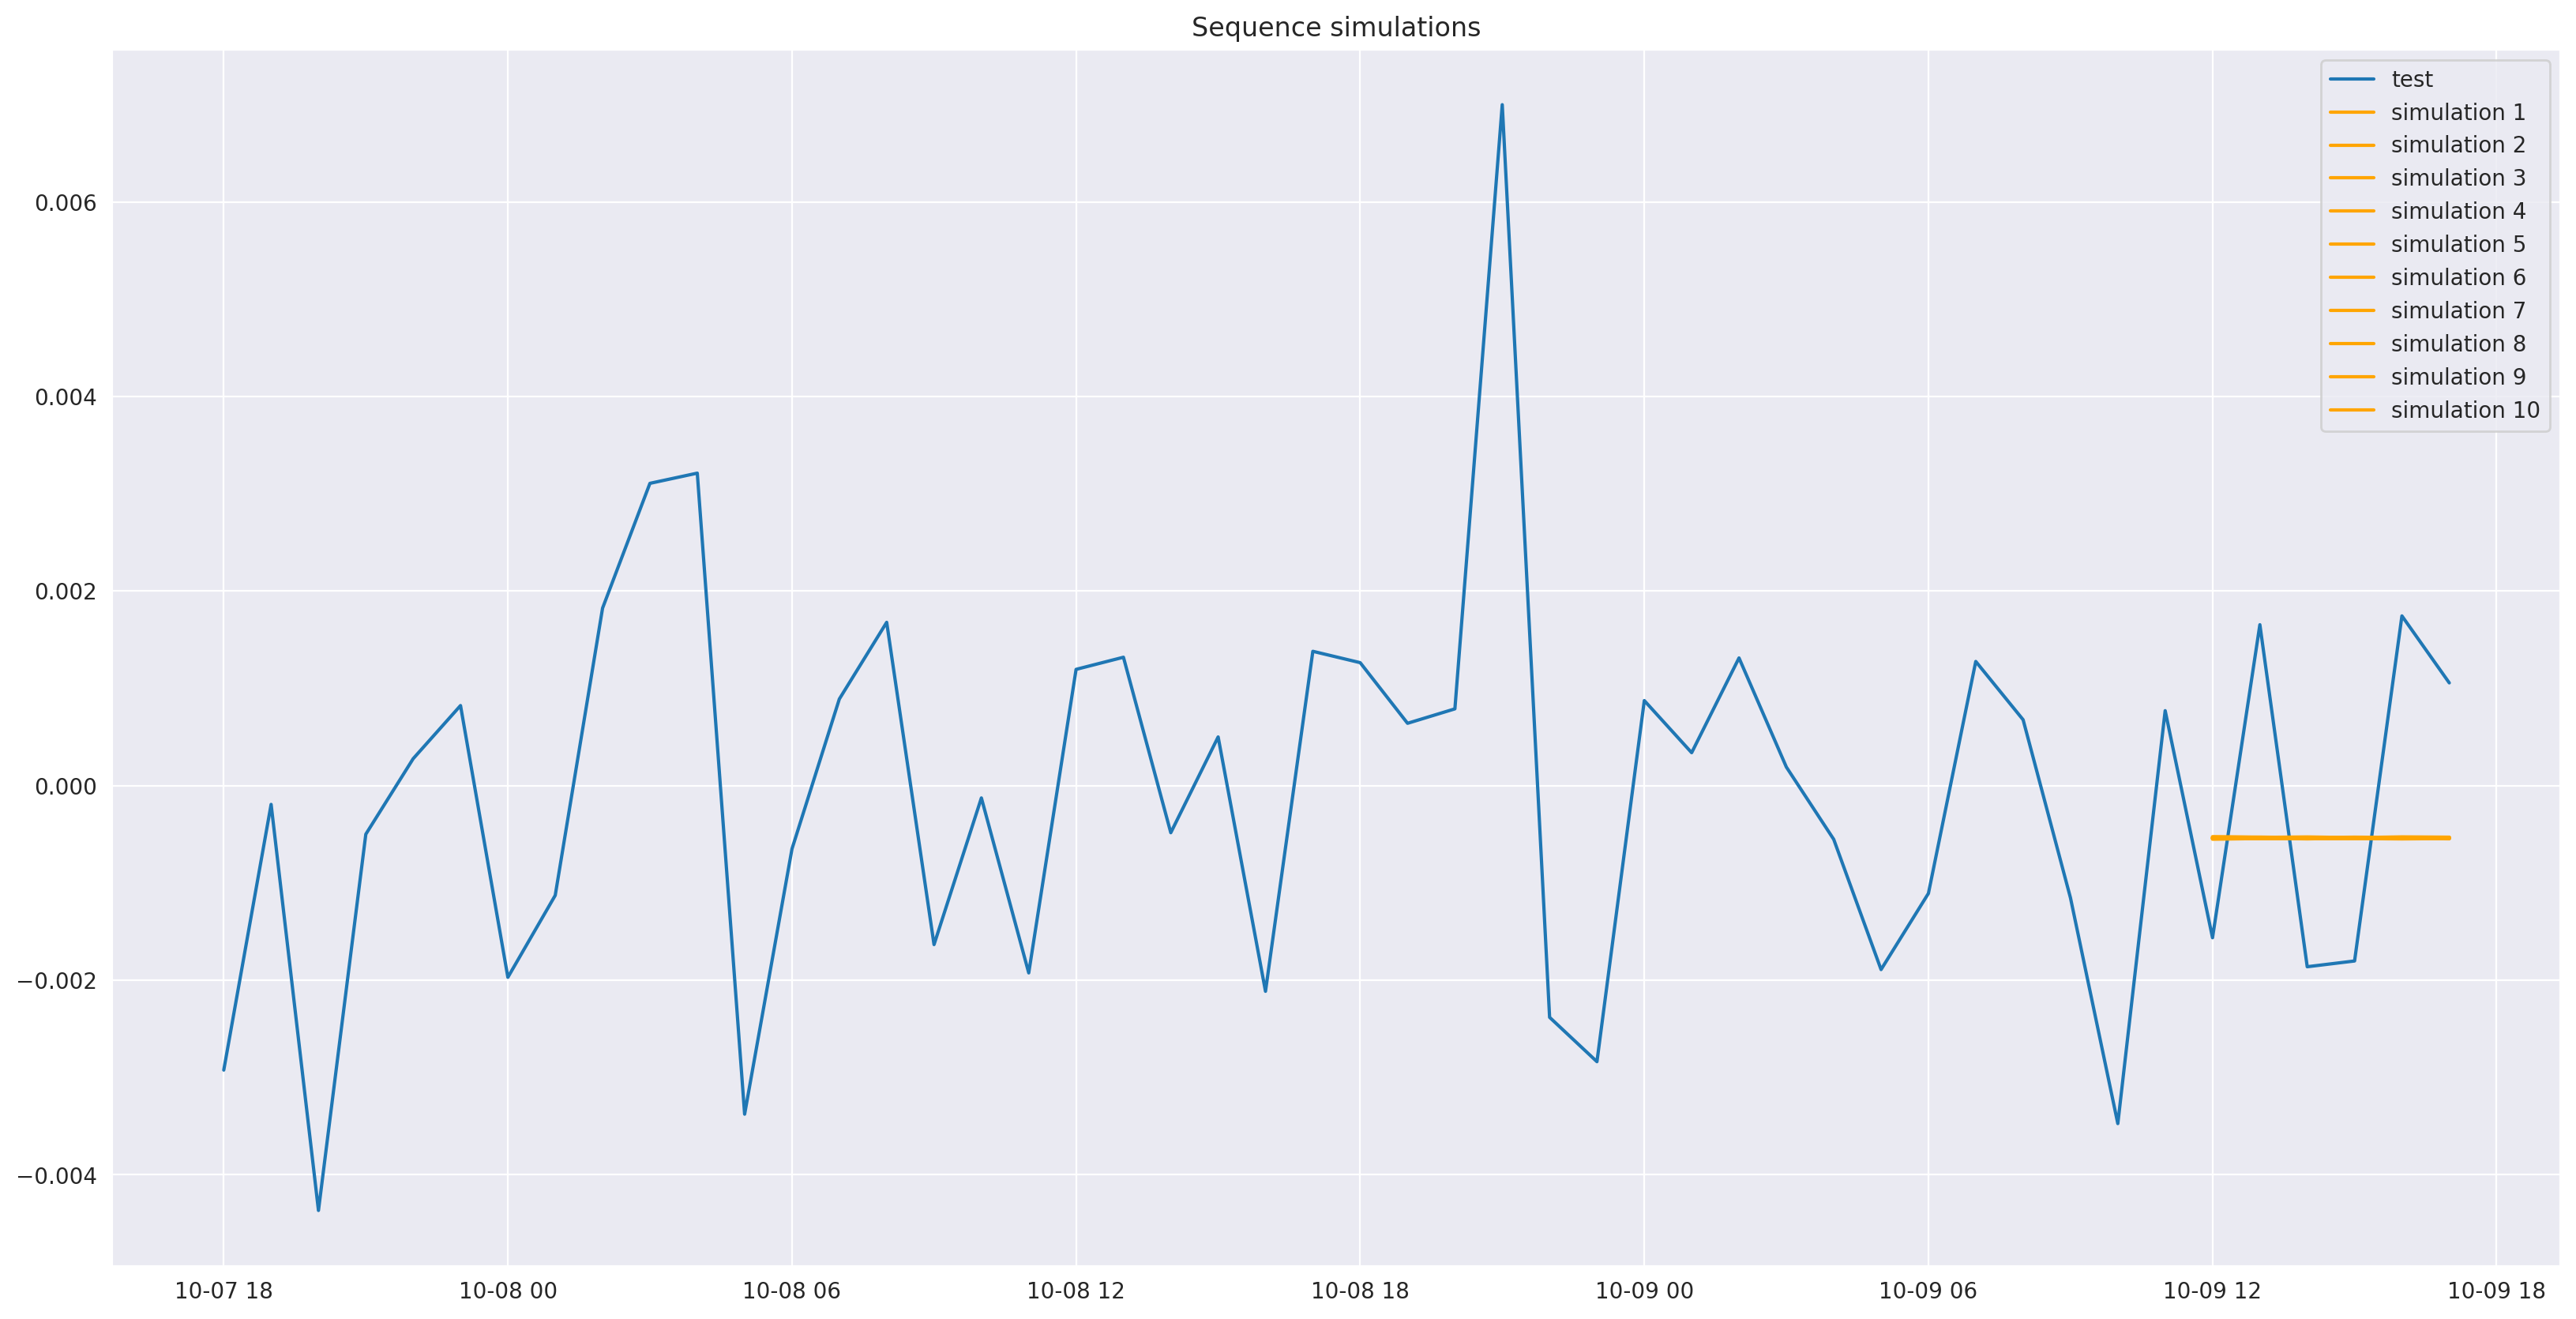

In [23]:
gen.eval()

num_estimations = 1000

local_window = window * 2
offset = randint(train_len, len(series) - local_window)
window_series = series.iloc[offset: offset + local_window]
head_series = window_series.iloc[-pred_len:]

condition = torch.tensor(window_series.values[-condition_size:], dtype=torch.float32, device=device).unsqueeze(0)

simulations = []
for batch_id in tqdm(range(max(num_estimations // batch_size, 1)), desc='Simulation'):
    with torch.no_grad():
        pred_sequences = gen(condition.repeat(batch_size, 1), torch.randn(batch_size, pred_len).type_as(condition))
    simulations.append(pred_sequences)
simulations = torch.cat(simulations, dim=0)

fig = plt.figure(figsize=(20, 10))
plt.plot(window_series.index, window_series * norm, label='test')

for idx, simulation in enumerate(choices(simulations, k=10)):
    plt.plot(head_series.index, simulation.detach().cpu().numpy() * norm, label=f'simulation {idx+1}', color='orange')
plt.legend()
plt.title(f'Sequence simulations')
plt.show()